In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np
from time import time

CUDA = torch.cuda.is_available()

### VAE Model

In [2]:
RAW_DATA_DIR = "../Data/Raw/"
PROCESSED_DATA_DIR = "../Data/Processed/VAE/Z2/"

class CovariateDataset(Dataset):
    def __init__(self, file_name_pattern, file_name_args):
        self.file_name = file_name_pattern.format(*file_name_args, "covar")
        self.assignment_file_name = file_name_pattern.format(*file_name_args, "assignment")
        
        self.data = np.loadtxt(RAW_DATA_DIR + self.file_name + ".csv", delimiter=",")[:, 1:] # remove bias
        self.assignment_data = np.loadtxt(RAW_DATA_DIR + self.assignment_file_name + ".csv", delimiter=",")
        
    def __getitem__(self, index):
        return (self.data[index].astype(float), 0)

    def __len__(self):
        return self.data.shape[0]
    
    def save_processed_data(self, data):
        name = PROCESSED_DATA_DIR + self.file_name+".csv"
        np.savetxt(name, data, delimiter=",")

In [17]:
# Based on an example from https://github.com/pytorch/examples/blob/master/vae/main.py
# Extended to place a different prior on binary vs normal vars

SEED = 1

ZDIMS = 2 # latent dimensions
INTERMEDIATE_DIMS = 128
INTERMEDIATE_DIMS_2 = 64
INTERMEDIATE_DIMS_3 = 32
FEATURES = 10
DIAG_VAR = True

BINARY = [0, 2, 5, 7, 8]
NORMAL = [1, 3, 5, 6, 9]

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

class ModifiedVAE(nn.Module):
    def __init__(self):
        super(ModifiedVAE, self).__init__()
        
        self.relu = nn.ReLU()
        
        # ENCODER LAYERS
        self.dense1 = nn.Linear(FEATURES, INTERMEDIATE_DIMS)
        self.dense1_2 = nn.Linear(INTERMEDIATE_DIMS, INTERMEDIATE_DIMS_2)
        self.dense1_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS_3)
        
        self.dense2_1 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # mu layer
        self.dense2_2 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # logvariance layer
        
        # this last layer bottlenecks through ZDIMS connections

        # DECODER LAYERS
        self.dense3 = nn.Linear(ZDIMS, INTERMEDIATE_DIMS_3)
        self.dense3_2 = nn.Linear(INTERMEDIATE_DIMS_3, INTERMEDIATE_DIMS_2)
        self.dense3_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS)
        
        self.dense4 = nn.Linear(INTERMEDIATE_DIMS, len(BINARY))
        self.dense5 = nn.Linear(INTERMEDIATE_DIMS, len(NORMAL))
        
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.dense1(x))
        h2 = self.relu(self.dense1_2(h1))
        h3 = self.relu(self.dense1_3(h2))
        
        return self.dense2_1(h3), self.dense2_2(h3) #mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            # If we sampled directly from the latent distribution
            # we wouldn't be able to backprop the results because
            # there is no clear grad on the distribution

            # This reparam samples from a unit gaussian and then scales
            # by the latent parameters giving a defined route to backprop.

            std = logvar.mul(0.5).exp_() 

            # Sample from a unit gaussian with dimensions matching
            # the latent space.
            eps = Variable(std.data.new(std.size()).normal_())

            return eps.mul(std).add_(mu) # rescale and return
        else:
            print("no sample")
            return mu

    def decode(self, z):
        h4 = self.relu(self.dense3(z))
        h5 = self.relu(self.dense3_2(h4))
        h6 = self.relu(self.dense3_3(h5))
        
        binary_mu_out = self.sigmoid(self.dense4(h6))
        normal_mu_out = self.dense5(h6)
        
        return binary_mu_out, normal_mu_out

    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x.view(-1, FEATURES))
        z = self.reparameterize(latent_mu, latent_logvar)
        binary_mu_out, normal_mu_out = self.decode(z)
        return binary_mu_out, normal_mu_out, latent_mu, latent_logvar

def loss_function(recon_binary_mu, recon_normal_mu, batch_x, mu_latent, logvar_latent):
    
    # MSE: how good is the reconstruction in terms of
    mse_loss = nn.MSELoss(size_average=False)
    normal_recon_loss = mse_loss(recon_normal_mu, batch_x[:, NORMAL])
    normal_recon_loss /= (batch_x.size()[0])
    
    # Cross Entropy:
    BCE = F.binary_cross_entropy(recon_binary_mu, batch_x[:, BINARY], size_average=False)
    BCE /= (batch_x.size()[0])
    
    # KLD is Kullback–Leibler divergence. Regularize VAE by
    # penalizing divergence from the prior

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_x.size()[0] * FEATURES
    
#     print("RL", normal_recon_loss.data.cpu().numpy()[0])
#     print("BCE", BCE.data.cpu().numpy()[0])
#     print("KLD", KLD.data.cpu().numpy()[0])
    
    return normal_recon_loss + BCE + KLD

def train(model, optimizer, epoch, data_loader, log_results=False):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(data_loader):
        data = Variable(data)
        data = data.float()
        if CUDA:
            data = data.cuda()
        
        optimizer.zero_grad()

        binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(data)
        
        # calculate loss
        loss = loss_function(binary_mu_out, normal_mu_out, data, mu_latent, logvar_latent)
        train_loss += loss.data[0]
        
        # Find the gradient and descend
        loss.backward()
        optimizer.step()
        
    if log_results:
        print('====> Epoch: {} Average loss: {:.8f}'.format(
              epoch, train_loss / len(data_loader.dataset)))

### Train and Process Utils

In [18]:
def train_model(model_class, dataset, dataset_number, verbose=True):
    model = model_class()
    if CUDA:
        model = model.cuda()

    num_epochs = 3000
    batch_size = 1000
    learning_rate = 1e-2
    lr_sched = False
         
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [int(num_epochs/4), int(3*num_epochs/4)], gamma=0.1)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(1, num_epochs+1):
        checkpoint_interval = int(num_epochs/10)
        
        if lr_sched:
            scheduler.step()

        log = False
        if epoch%checkpoint_interval == 0:
            log = True
            
        train(model, optimizer, epoch, data_loader, log_results=log)
    

    torch.save(model.state_dict(), "../Models/VAE_{}.pth".format(dataset_number))
    
    # Show reconstruction
    model.eval()
    print("Training state: ", model.training)
    
    original_data,_ = next(iter(data_loader))
    original_data = Variable(original_data)
    original_data = original_data.float()
    if CUDA:
        original_data = original_data.cuda()
        
    binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(original_data)
    
    return model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent

def encode_data(model, dataset):
    all_data = torch.from_numpy(dataset.data)
    all_data = Variable(all_data)
    all_data = all_data.float()
    
    if CUDA:
        all_data = all_data.cuda()
    
    model.eval()
    latent_mu, latent_var = model.encode(all_data)
    
    if CUDA:
        latent_mu = latent_mu.cpu()
        latent_var = latent_var.cpu()
        
    data = np.hstack([latent_mu.data.numpy(), latent_var.data.numpy()])
    dataset.save_processed_data(data)

In [15]:
dataset = CovariateDataset("n_{}_model_{}_v_{}_{}_data", [1000, "A_add_lin", 0])
trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
    train_model(ModifiedVAE, dataset, 1,verbose=True)

encode_data(trained_model, dataset)

====> Epoch: 1000 Average loss: 0.00277041
====> Epoch: 2000 Average loss: 0.00207642
====> Epoch: 3000 Average loss: 0.00367876
====> Epoch: 4000 Average loss: 0.00173663
====> Epoch: 5000 Average loss: 0.00233836
====> Epoch: 6000 Average loss: 0.00162026
====> Epoch: 7000 Average loss: 0.00157601
====> Epoch: 8000 Average loss: 0.00175528
====> Epoch: 9000 Average loss: 0.00206262
====> Epoch: 10000 Average loss: 0.00158404
Training state:  False
no sample


In [137]:
mu_out = torch.Tensor(1000, 10)

for index in BINARY:
    mu_out[:, index] = binary_mu_out[:, BINARY.index(index)].data.cpu()
    
for index in NORMAL:
    mu_out[:, index] = normal_mu_out[:, NORMAL.index(index)].data.cpu()
    
for i in np.random.choice(list(range(1000)), size=5, ):
    print("Orginal:", list(np.round(original_data[i].data.cpu().numpy(), 2)))
    print("Mu out:", list(np.round(mu_out[i].numpy(), 2)))
    print("Mu Latent:", list(np.round(mu_latent[i].data.cpu().numpy(), 2)))
    print("Std latent:", list(np.round(np.exp(logvar_latent[i].mul(0.5).exp().data.cpu().numpy()), 2)**2))
    print()

Orginal: [0.0, -1.0, 0.0, -2.0, 0.62, 1.0, 0.13, 0.0, 1.0, -0.27]
Mu out: [0.0, -1.01, 0.0, -1.97, 0.0, 0.85, 0.63, 0.0, 1.0, 0.12]
Mu Latent: [1.04, 0.69]
Std latent: [1.0403999, 1.0403999]

Orginal: [1.0, 1.28, 0.0, 0.0, -1.12, 1.0, 1.71, 1.0, 0.0, 0.57]
Mu out: [1.0, 1.11, 0.0, 0.37, 0.0, 1.15, 1.26, 1.0, 0.0, 0.28]
Mu Latent: [-1.57, -2.28]
Std latent: [1.0403999, 1.0816]

Orginal: [1.0, 0.95, 0.0, 0.65, 0.16, 0.0, 1.24, 1.0, 1.0, 0.01]
Mu out: [1.0, 0.95, 0.01, 0.52, 0.0, -0.07, 0.37, 1.0, 1.0, -0.62]
Mu Latent: [0.43, -1.49]
Std latent: [1.0201, 1.0609]

Orginal: [0.0, -0.09, 1.0, -0.83, -0.83, 0.0, 1.26, 0.0, 1.0, 0.41]
Mu out: [0.0, 0.03, 1.0, -0.91, 0.0, 0.11, 1.04, 0.0, 1.0, 0.53]
Mu Latent: [0.65, 0.61]
Std latent: [1.0201, 1.0201]

Orginal: [1.0, -0.85, 1.0, 0.08, 0.72, 0.0, 0.13, 0.0, 1.0, -1.81]
Mu out: [1.0, -0.2, 1.0, 0.43, 0.0, 0.19, 0.72, 0.0, 1.0, -2.12]
Mu Latent: [0.24, -0.2]
Std latent: [1.0201, 1.0201]



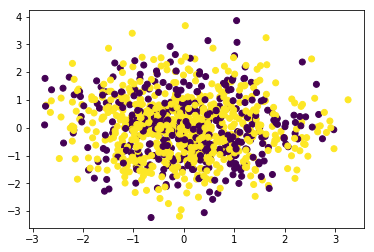

In [138]:
x = mu_latent[:, 0].data.cpu().numpy()
y = mu_latent[:, 1].data.cpu().numpy()

x_std = list(np.round(np.exp(logvar_latent[:, 0].mul(0.5).exp().data.cpu().numpy()), 2)**2)
y_std = list(np.round(np.exp(logvar_latent[:, 1].mul(0.5).exp().data.cpu().numpy()), 2)**2)

plt.scatter(x, y, c=dataset.assignment_data)
# plt.errorbar(x[:10], y[:10], yerr=y_std[:10], xerr=x_std[:10])
plt.show()


### Data Processing

In [19]:
assignment_model_names = ['A_add_lin', 'B_add_mild_nlin', 'C_add_mod_nlin', 'D_mild_nadd_lin',
                     'E_mild_nadd_mild_nlin', 'F_mod_nadd_lin', 'G_mod_nadd_mod_nlin']

for dataset_number in range(0, 200):
    print("Starting run for Dataset {}".format(dataset_number))
    
    for model_name in assignment_model_names:
        print("-- Running for model name: ", model_name)
        
        start = time()

        dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])

        trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
            train_model(ModifiedVAE, dataset, dataset_number,verbose=True)

        encode_data(trained_model, dataset)

        print("---- Done in ", time() - start, " seconds\n")
                
    print("================\n\n")

Starting run for Dataset 0
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00416072
====> Epoch: 600 Average loss: 0.00334525
====> Epoch: 900 Average loss: 0.00351044
====> Epoch: 1200 Average loss: 0.00256321
====> Epoch: 1500 Average loss: 0.00237462
====> Epoch: 1800 Average loss: 0.00321734
====> Epoch: 2100 Average loss: 0.00218389
====> Epoch: 2400 Average loss: 0.00210887
====> Epoch: 2700 Average loss: 0.00200297
====> Epoch: 3000 Average loss: 0.00192780
Training state:  False
no sample
---- Done in  28.6343834400177  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00435627
====> Epoch: 600 Average loss: 0.00343159
====> Epoch: 900 Average loss: 0.00299888
====> Epoch: 1200 Average loss: 0.00354046
====> Epoch: 1500 Average loss: 0.00240458
====> Epoch: 1800 Average loss: 0.00220577
====> Epoch: 2100 Average loss: 0.00226046
====> Epoch: 2400 Average loss: 0.00210684
====> Epoch: 2700 Average loss: 0.00362390
====> 

====> Epoch: 3000 Average loss: 0.00180868
Training state:  False
no sample
---- Done in  29.474335432052612  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00451368
====> Epoch: 600 Average loss: 0.00353760
====> Epoch: 900 Average loss: 0.00305133
====> Epoch: 1200 Average loss: 0.00278770
====> Epoch: 1500 Average loss: 0.00257376
====> Epoch: 1800 Average loss: 0.00248083
====> Epoch: 2100 Average loss: 0.00244834
====> Epoch: 2400 Average loss: 0.00232785
====> Epoch: 2700 Average loss: 0.00225521
====> Epoch: 3000 Average loss: 0.00218893
Training state:  False
no sample
---- Done in  29.0731680393219  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00416307
====> Epoch: 600 Average loss: 0.00327675
====> Epoch: 900 Average loss: 0.00266360
====> Epoch: 1200 Average loss: 0.00242134
====> Epoch: 1500 Average loss: 0.00219348
====> Epoch: 1800 Average loss: 0.00216544
====> Epoch: 2100 Average loss: 0.0019

====> Epoch: 2400 Average loss: 0.00199628
====> Epoch: 2700 Average loss: 0.00191673
====> Epoch: 3000 Average loss: 0.00185112
Training state:  False
no sample
---- Done in  29.07337236404419  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00416345
====> Epoch: 600 Average loss: 0.00303069
====> Epoch: 900 Average loss: 0.00280711
====> Epoch: 1200 Average loss: 0.00223634
====> Epoch: 1500 Average loss: 0.00209521
====> Epoch: 1800 Average loss: 0.00373985
====> Epoch: 2100 Average loss: 0.00183209
====> Epoch: 2400 Average loss: 0.00180489
====> Epoch: 2700 Average loss: 0.00173659
====> Epoch: 3000 Average loss: 0.00180719
Training state:  False
no sample
---- Done in  29.01887559890747  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00402515
====> Epoch: 600 Average loss: 0.00350159
====> Epoch: 900 Average loss: 0.00273398
====> Epoch: 1200 Average loss: 0.00238033
====> Epoch: 1500 Average loss: 0.0022

====> Epoch: 1800 Average loss: 0.00270377
====> Epoch: 2100 Average loss: 0.00265559
====> Epoch: 2400 Average loss: 0.00256734
====> Epoch: 2700 Average loss: 0.00240632
====> Epoch: 3000 Average loss: 0.00244451
Training state:  False
no sample
---- Done in  28.921577215194702  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00421780
====> Epoch: 600 Average loss: 0.00343433
====> Epoch: 900 Average loss: 0.00289091
====> Epoch: 1200 Average loss: 0.00250864
====> Epoch: 1500 Average loss: 0.00237478
====> Epoch: 1800 Average loss: 0.00221906
====> Epoch: 2100 Average loss: 0.00208154
====> Epoch: 2400 Average loss: 0.00200559
====> Epoch: 2700 Average loss: 0.00197003
====> Epoch: 3000 Average loss: 0.00191705
Training state:  False
no sample
---- Done in  29.01532793045044  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00429370
====> Epoch: 600 Average loss: 0.00363838
====> Epoch: 900 Average loss

====> Epoch: 1200 Average loss: 0.00306515
====> Epoch: 1500 Average loss: 0.00250555
====> Epoch: 1800 Average loss: 0.00276019
====> Epoch: 2100 Average loss: 0.00226493
====> Epoch: 2400 Average loss: 0.00289023
====> Epoch: 2700 Average loss: 0.00344458
====> Epoch: 3000 Average loss: 0.00209519
Training state:  False
no sample
---- Done in  29.350019454956055  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00421277
====> Epoch: 600 Average loss: 0.00350764
====> Epoch: 900 Average loss: 0.00439175
====> Epoch: 1200 Average loss: 0.00262511
====> Epoch: 1500 Average loss: 0.00259620
====> Epoch: 1800 Average loss: 0.00220782
====> Epoch: 2100 Average loss: 0.00215777
====> Epoch: 2400 Average loss: 0.00199903
====> Epoch: 2700 Average loss: 0.00199093
====> Epoch: 3000 Average loss: 0.00191638
Training state:  False
no sample
---- Done in  29.339847326278687  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average lo

====> Epoch: 600 Average loss: 0.00330687
====> Epoch: 900 Average loss: 0.00276232
====> Epoch: 1200 Average loss: 0.00253654
====> Epoch: 1500 Average loss: 0.00270760
====> Epoch: 1800 Average loss: 0.00231593
====> Epoch: 2100 Average loss: 0.00217821
====> Epoch: 2400 Average loss: 0.00199355
====> Epoch: 2700 Average loss: 0.00194202
====> Epoch: 3000 Average loss: 0.00194171
Training state:  False
no sample
---- Done in  29.309569120407104  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00454231
====> Epoch: 600 Average loss: 0.00360548
====> Epoch: 900 Average loss: 0.00311452
====> Epoch: 1200 Average loss: 0.00281647
====> Epoch: 1500 Average loss: 0.00266700
====> Epoch: 1800 Average loss: 0.00247017
====> Epoch: 2100 Average loss: 0.00238439
====> Epoch: 2400 Average loss: 0.00222811
====> Epoch: 2700 Average loss: 0.00248277
====> Epoch: 3000 Average loss: 0.00373176
Training state:  False
no sample
---- Done in  28.58928894996643  sec

====> Epoch: 300 Average loss: 0.00427717
====> Epoch: 600 Average loss: 0.00343283
====> Epoch: 900 Average loss: 0.00297837
====> Epoch: 1200 Average loss: 0.00258179
====> Epoch: 1500 Average loss: 0.00228922
====> Epoch: 1800 Average loss: 0.00213267
====> Epoch: 2100 Average loss: 0.00252424
====> Epoch: 2400 Average loss: 0.00203704
====> Epoch: 2700 Average loss: 0.00192438
====> Epoch: 3000 Average loss: 0.00194092
Training state:  False
no sample
---- Done in  28.546265602111816  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00432453
====> Epoch: 600 Average loss: 0.00357648
====> Epoch: 900 Average loss: 0.00309753
====> Epoch: 1200 Average loss: 0.00267026
====> Epoch: 1500 Average loss: 0.00250243
====> Epoch: 1800 Average loss: 0.00272449
====> Epoch: 2100 Average loss: 0.00280529
====> Epoch: 2400 Average loss: 0.00218351
====> Epoch: 2700 Average loss: 0.00215438
====> Epoch: 3000 Average loss: 0.00197981
Training state:  False

====> Epoch: 300 Average loss: 0.00453075
====> Epoch: 600 Average loss: 0.00363067
====> Epoch: 900 Average loss: 0.00325965
====> Epoch: 1200 Average loss: 0.00272676
====> Epoch: 1500 Average loss: 0.00307128
====> Epoch: 1800 Average loss: 0.00243277
====> Epoch: 2100 Average loss: 0.00228303
====> Epoch: 2400 Average loss: 0.00217317
====> Epoch: 2700 Average loss: 0.00209856
====> Epoch: 3000 Average loss: 0.00241716
Training state:  False
no sample
---- Done in  28.432727813720703  seconds



Starting run for Dataset 15
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00421560
====> Epoch: 600 Average loss: 0.00357250
====> Epoch: 900 Average loss: 0.00303650
====> Epoch: 1200 Average loss: 0.00266513
====> Epoch: 1500 Average loss: 0.00232188
====> Epoch: 1800 Average loss: 0.00268802
====> Epoch: 2100 Average loss: 0.00209765
====> Epoch: 2400 Average loss: 0.00202455
====> Epoch: 2700 Average loss: 0.00200070
====> Epoch: 3000 Average loss: 0.00187223
Tr

====> Epoch: 300 Average loss: 0.00414204
====> Epoch: 600 Average loss: 0.00359240
====> Epoch: 900 Average loss: 0.00312741
====> Epoch: 1200 Average loss: 0.00279332
====> Epoch: 1500 Average loss: 0.00273124
====> Epoch: 1800 Average loss: 0.00267955
====> Epoch: 2100 Average loss: 0.00234420
====> Epoch: 2400 Average loss: 0.00257460
====> Epoch: 2700 Average loss: 0.00225079
====> Epoch: 3000 Average loss: 0.00223814
Training state:  False
no sample
---- Done in  28.77577519416809  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00419007
====> Epoch: 600 Average loss: 0.00340515
====> Epoch: 900 Average loss: 0.00293298
====> Epoch: 1200 Average loss: 0.00269816
====> Epoch: 1500 Average loss: 0.00252713
====> Epoch: 1800 Average loss: 0.00237044
====> Epoch: 2100 Average loss: 0.00236919
====> Epoch: 2400 Average loss: 0.00211055
====> Epoch: 2700 Average loss: 0.00208997
====> Epoch: 3000 Average loss: 0.00212733
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00430151
====> Epoch: 600 Average loss: 0.00348989
====> Epoch: 900 Average loss: 0.00290773
====> Epoch: 1200 Average loss: 0.00263433
====> Epoch: 1500 Average loss: 0.00246756
====> Epoch: 1800 Average loss: 0.00229895
====> Epoch: 2100 Average loss: 0.00209035
====> Epoch: 2400 Average loss: 0.00266618
====> Epoch: 2700 Average loss: 0.00199045
====> Epoch: 3000 Average loss: 0.00198657
Training state:  False
no sample
---- Done in  28.504104137420654  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00434723
====> Epoch: 600 Average loss: 0.00331926
====> Epoch: 900 Average loss: 0.00282901
====> Epoch: 1200 Average loss: 0.00246756
====> Epoch: 1500 Average loss: 0.00231975
====> Epoch: 1800 Average loss: 0.00225765
====> Epoch: 2100 Average loss: 0.00216643
====> Epoch: 2400 Average loss: 0.00204558
====> Epoch: 2700 Average loss: 0.00206098
====> Epoch: 3000 Average loss: 0.00194279
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00412973
====> Epoch: 600 Average loss: 0.00326158
====> Epoch: 900 Average loss: 0.00261670
====> Epoch: 1200 Average loss: 0.00235171
====> Epoch: 1500 Average loss: 0.00211183
====> Epoch: 1800 Average loss: 0.00199430
====> Epoch: 2100 Average loss: 0.00196402
====> Epoch: 2400 Average loss: 0.00186231
====> Epoch: 2700 Average loss: 0.00186174
====> Epoch: 3000 Average loss: 0.00175150
Training state:  False
no sample
---- Done in  28.871392965316772  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00413136
====> Epoch: 600 Average loss: 0.00344173
====> Epoch: 900 Average loss: 0.00287010
====> Epoch: 1200 Average loss: 0.00254641
====> Epoch: 1500 Average loss: 0.00268218
====> Epoch: 1800 Average loss: 0.00216628
====> Epoch: 2100 Average loss: 0.00206394
====> Epoch: 2400 Average loss: 0.00203238
====> Epoch: 2700 Average loss: 0.00197786
====> Epoch: 3000 Average loss: 0.00208950
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00412382
====> Epoch: 600 Average loss: 0.00360273
====> Epoch: 900 Average loss: 0.00277974
====> Epoch: 1200 Average loss: 0.00253767
====> Epoch: 1500 Average loss: 0.00232937
====> Epoch: 1800 Average loss: 0.00235984
====> Epoch: 2100 Average loss: 0.00215804
====> Epoch: 2400 Average loss: 0.00211962
====> Epoch: 2700 Average loss: 0.00210159
====> Epoch: 3000 Average loss: 0.00326084
Training state:  False
no sample
---- Done in  28.86342144012451  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00423100
====> Epoch: 600 Average loss: 0.00328152
====> Epoch: 900 Average loss: 0.00290741
====> Epoch: 1200 Average loss: 0.00267100
====> Epoch: 1500 Average loss: 0.00219927
====> Epoch: 1800 Average loss: 0.00214745
====> Epoch: 2100 Average loss: 0.00198732
====> Epoch: 2400 Average loss: 0.00191399
====> Epoch: 2700 Average loss: 0.00202748
====> Epoch: 3000 Average loss: 0.00189862
Training state:  Fals

====> Epoch: 300 Average loss: 0.00421850
====> Epoch: 600 Average loss: 0.00319213
====> Epoch: 900 Average loss: 0.00284337
====> Epoch: 1200 Average loss: 0.00247830
====> Epoch: 1500 Average loss: 0.00223047
====> Epoch: 1800 Average loss: 0.00223975
====> Epoch: 2100 Average loss: 0.00195601
====> Epoch: 2400 Average loss: 0.00191177
====> Epoch: 2700 Average loss: 0.00195789
====> Epoch: 3000 Average loss: 0.00176563
Training state:  False
no sample
---- Done in  28.386738777160645  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00455845
====> Epoch: 600 Average loss: 0.00379703
====> Epoch: 900 Average loss: 0.00314148
====> Epoch: 1200 Average loss: 0.00311151
====> Epoch: 1500 Average loss: 0.00264601
====> Epoch: 1800 Average loss: 0.00239338
====> Epoch: 2100 Average loss: 0.00233204
====> Epoch: 2400 Average loss: 0.00251263
====> Epoch: 2700 Average loss: 0.00212871
====> Epoch: 3000 Average loss: 0.00216391
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00413565
====> Epoch: 600 Average loss: 0.00334085
====> Epoch: 900 Average loss: 0.00287078
====> Epoch: 1200 Average loss: 0.00294283
====> Epoch: 1500 Average loss: 0.00274143
====> Epoch: 1800 Average loss: 0.00219330
====> Epoch: 2100 Average loss: 0.00205187
====> Epoch: 2400 Average loss: 0.00198396
====> Epoch: 2700 Average loss: 0.00206483
====> Epoch: 3000 Average loss: 0.00188992
Training state:  False
no sample
---- Done in  28.366349458694458  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00412961
====> Epoch: 600 Average loss: 0.00314378
====> Epoch: 900 Average loss: 0.00264409
====> Epoch: 1200 Average loss: 0.00246622
====> Epoch: 1500 Average loss: 0.00224776
====> Epoch: 1800 Average loss: 0.00193962
====> Epoch: 2100 Average loss: 0.00203112
====> Epoch: 2400 Average loss: 0.00179422
====> Epoch: 2700 Average loss: 0.00189341
====> Epoch: 3000 Average loss: 0.00173575
Training state:  False

====> Epoch: 300 Average loss: 0.00423682
====> Epoch: 600 Average loss: 0.00328918
====> Epoch: 900 Average loss: 0.00276110
====> Epoch: 1200 Average loss: 0.00265141
====> Epoch: 1500 Average loss: 0.00251249
====> Epoch: 1800 Average loss: 0.00211739
====> Epoch: 2100 Average loss: 0.00202261
====> Epoch: 2400 Average loss: 0.00197179
====> Epoch: 2700 Average loss: 0.00191225
====> Epoch: 3000 Average loss: 0.00370130
Training state:  False
no sample
---- Done in  28.528883457183838  seconds



Starting run for Dataset 30
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00423922
====> Epoch: 600 Average loss: 0.00340560
====> Epoch: 900 Average loss: 0.00281883
====> Epoch: 1200 Average loss: 0.00250480
====> Epoch: 1500 Average loss: 0.00324664
====> Epoch: 1800 Average loss: 0.00223402
====> Epoch: 2100 Average loss: 0.00219609
====> Epoch: 2400 Average loss: 0.00224114
====> Epoch: 2700 Average loss: 0.00193209
====> Epoch: 3000 Average loss: 0.00193339
Tr

====> Epoch: 300 Average loss: 0.00413127
====> Epoch: 600 Average loss: 0.00339626
====> Epoch: 900 Average loss: 0.00280478
====> Epoch: 1200 Average loss: 0.00250094
====> Epoch: 1500 Average loss: 0.00231065
====> Epoch: 1800 Average loss: 0.00210466
====> Epoch: 2100 Average loss: 0.00262202
====> Epoch: 2400 Average loss: 0.00191179
====> Epoch: 2700 Average loss: 0.00185548
====> Epoch: 3000 Average loss: 0.00183860
Training state:  False
no sample
---- Done in  28.659643173217773  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00406151
====> Epoch: 600 Average loss: 0.00342250
====> Epoch: 900 Average loss: 0.00296973
====> Epoch: 1200 Average loss: 0.00275915
====> Epoch: 1500 Average loss: 0.00240341
====> Epoch: 1800 Average loss: 0.00234347
====> Epoch: 2100 Average loss: 0.00221461
====> Epoch: 2400 Average loss: 0.00209305
====> Epoch: 2700 Average loss: 0.00216416
====> Epoch: 3000 Average loss: 0.00194089
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00426305
====> Epoch: 600 Average loss: 0.00336435
====> Epoch: 900 Average loss: 0.00293078
====> Epoch: 1200 Average loss: 0.00258943
====> Epoch: 1500 Average loss: 0.00239236
====> Epoch: 1800 Average loss: 0.00245666
====> Epoch: 2100 Average loss: 0.00225670
====> Epoch: 2400 Average loss: 0.00215897
====> Epoch: 2700 Average loss: 0.00209660
====> Epoch: 3000 Average loss: 0.00303058
Training state:  False
no sample
---- Done in  28.5707585811615  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00418697
====> Epoch: 600 Average loss: 0.00393759
====> Epoch: 900 Average loss: 0.00300772
====> Epoch: 1200 Average loss: 0.00253336
====> Epoch: 1500 Average loss: 0.00240299
====> Epoch: 1800 Average loss: 0.00223285
====> Epoch: 2100 Average loss: 0.00209315
====> Epoch: 2400 Average loss: 0.00200683
====> Epoch: 2700 Average loss: 0.00195398
====> Epoch: 3000 Average loss: 0.00195612
Training state:  False
no sam

====> Epoch: 300 Average loss: 0.00440149
====> Epoch: 600 Average loss: 0.00351581
====> Epoch: 900 Average loss: 0.00295022
====> Epoch: 1200 Average loss: 0.00261984
====> Epoch: 1500 Average loss: 0.00367625
====> Epoch: 1800 Average loss: 0.00226163
====> Epoch: 2100 Average loss: 0.00214716
====> Epoch: 2400 Average loss: 0.00217784
====> Epoch: 2700 Average loss: 0.00354795
====> Epoch: 3000 Average loss: 0.00208404
Training state:  False
no sample
---- Done in  28.72072744369507  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00406619
====> Epoch: 600 Average loss: 0.00331975
====> Epoch: 900 Average loss: 0.00268456
====> Epoch: 1200 Average loss: 0.00260593
====> Epoch: 1500 Average loss: 0.00218730
====> Epoch: 1800 Average loss: 0.00242208
====> Epoch: 2100 Average loss: 0.00200358
====> Epoch: 2400 Average loss: 0.00200014
====> Epoch: 2700 Average loss: 0.00215245
====> Epoch: 3000 Average loss: 0.00183720
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00413971
====> Epoch: 600 Average loss: 0.00344392
====> Epoch: 900 Average loss: 0.00294310
====> Epoch: 1200 Average loss: 0.00255818
====> Epoch: 1500 Average loss: 0.00235332
====> Epoch: 1800 Average loss: 0.00223189
====> Epoch: 2100 Average loss: 0.00214801
====> Epoch: 2400 Average loss: 0.00210180
====> Epoch: 2700 Average loss: 0.00191806
====> Epoch: 3000 Average loss: 0.00201604
Training state:  False
no sample
---- Done in  28.47489595413208  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00414284
====> Epoch: 600 Average loss: 0.00326733
====> Epoch: 900 Average loss: 0.00296763
====> Epoch: 1200 Average loss: 0.00243541
====> Epoch: 1500 Average loss: 0.00222438
====> Epoch: 1800 Average loss: 0.00238288
====> Epoch: 2100 Average loss: 0.00205794
====> Epoch: 2400 Average loss: 0.00190687
====> Epoch: 2700 Average loss: 0.00206485
====> Epoch: 3000 Average loss: 0.00176369
Training state:  Fals

====> Epoch: 300 Average loss: 0.00424480
====> Epoch: 600 Average loss: 0.00353226
====> Epoch: 900 Average loss: 0.00296499
====> Epoch: 1200 Average loss: 0.00259921
====> Epoch: 1500 Average loss: 0.00252130
====> Epoch: 1800 Average loss: 0.00228927
====> Epoch: 2100 Average loss: 0.00219123
====> Epoch: 2400 Average loss: 0.00217205
====> Epoch: 2700 Average loss: 0.00204588
====> Epoch: 3000 Average loss: 0.00201832
Training state:  False
no sample
---- Done in  28.241374492645264  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00427746
====> Epoch: 600 Average loss: 0.00342370
====> Epoch: 900 Average loss: 0.00303473
====> Epoch: 1200 Average loss: 0.00261015
====> Epoch: 1500 Average loss: 0.00284683
====> Epoch: 1800 Average loss: 0.00235671
====> Epoch: 2100 Average loss: 0.00214436
====> Epoch: 2400 Average loss: 0.00204363
====> Epoch: 2700 Average loss: 0.00198540
====> Epoch: 3000 Average loss: 0.00204421
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00407507
====> Epoch: 600 Average loss: 0.00352080
====> Epoch: 900 Average loss: 0.00287371
====> Epoch: 1200 Average loss: 0.00260422
====> Epoch: 1500 Average loss: 0.00244211
====> Epoch: 1800 Average loss: 0.00210837
====> Epoch: 2100 Average loss: 0.00204239
====> Epoch: 2400 Average loss: 0.00230501
====> Epoch: 2700 Average loss: 0.00191880
====> Epoch: 3000 Average loss: 0.00203833
Training state:  False
no sample
---- Done in  28.56443190574646  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00407873
====> Epoch: 600 Average loss: 0.00322692
====> Epoch: 900 Average loss: 0.00266367
====> Epoch: 1200 Average loss: 0.00243530
====> Epoch: 1500 Average loss: 0.00250100
====> Epoch: 1800 Average loss: 0.00207599
====> Epoch: 2100 Average loss: 0.00280587
====> Epoch: 2400 Average loss: 0.00219398
====> Epoch: 2700 Average loss: 0.00200471
====> Epoch: 3000 Average loss: 0.00188928
Training state:  False


====> Epoch: 300 Average loss: 0.00441906
====> Epoch: 600 Average loss: 0.00350553
====> Epoch: 900 Average loss: 0.00295459
====> Epoch: 1200 Average loss: 0.00271271
====> Epoch: 1500 Average loss: 0.00240321
====> Epoch: 1800 Average loss: 0.00227717
====> Epoch: 2100 Average loss: 0.00515957
====> Epoch: 2400 Average loss: 0.00218993
====> Epoch: 2700 Average loss: 0.00202071
====> Epoch: 3000 Average loss: 0.00188606
Training state:  False
no sample
---- Done in  28.374478816986084  seconds



Starting run for Dataset 45
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00419336
====> Epoch: 600 Average loss: 0.00332639
====> Epoch: 900 Average loss: 0.00282261
====> Epoch: 1200 Average loss: 0.00251906
====> Epoch: 1500 Average loss: 0.00227845
====> Epoch: 1800 Average loss: 0.00302436
====> Epoch: 2100 Average loss: 0.00229225
====> Epoch: 2400 Average loss: 0.00204421
====> Epoch: 2700 Average loss: 0.00202571
====> Epoch: 3000 Average loss: 0.00192108
Tr

====> Epoch: 300 Average loss: 0.00408740
====> Epoch: 600 Average loss: 0.00326126
====> Epoch: 900 Average loss: 0.00293072
====> Epoch: 1200 Average loss: 0.00240575
====> Epoch: 1500 Average loss: 0.00213810
====> Epoch: 1800 Average loss: 0.00198372
====> Epoch: 2100 Average loss: 0.00192876
====> Epoch: 2400 Average loss: 0.00185276
====> Epoch: 2700 Average loss: 0.00181137
====> Epoch: 3000 Average loss: 0.00184168
Training state:  False
no sample
---- Done in  28.862326860427856  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00432862
====> Epoch: 600 Average loss: 0.00325958
====> Epoch: 900 Average loss: 0.00264709
====> Epoch: 1200 Average loss: 0.00234836
====> Epoch: 1500 Average loss: 0.00212011
====> Epoch: 1800 Average loss: 0.00270432
====> Epoch: 2100 Average loss: 0.00213836
====> Epoch: 2400 Average loss: 0.00191849
====> Epoch: 2700 Average loss: 0.00186019
====> Epoch: 3000 Average loss: 0.00181114
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00402683
====> Epoch: 600 Average loss: 0.00326393
====> Epoch: 900 Average loss: 0.00290407
====> Epoch: 1200 Average loss: 0.00270383
====> Epoch: 1500 Average loss: 0.00267086
====> Epoch: 1800 Average loss: 0.00212523
====> Epoch: 2100 Average loss: 0.00349793
====> Epoch: 2400 Average loss: 0.00198288
====> Epoch: 2700 Average loss: 0.00188845
====> Epoch: 3000 Average loss: 0.00218962
Training state:  False
no sample
---- Done in  29.119450569152832  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00471173
====> Epoch: 600 Average loss: 0.00374093
====> Epoch: 900 Average loss: 0.00344883
====> Epoch: 1200 Average loss: 0.00296803
====> Epoch: 1500 Average loss: 0.00266508
====> Epoch: 1800 Average loss: 0.00272404
====> Epoch: 2100 Average loss: 0.00242529
====> Epoch: 2400 Average loss: 0.00229886
====> Epoch: 2700 Average loss: 0.00225346
====> Epoch: 3000 Average loss: 0.00217498
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00412309
====> Epoch: 600 Average loss: 0.00327007
====> Epoch: 900 Average loss: 0.00279491
====> Epoch: 1200 Average loss: 0.00247594
====> Epoch: 1500 Average loss: 0.00223400
====> Epoch: 1800 Average loss: 0.00212890
====> Epoch: 2100 Average loss: 0.00196217
====> Epoch: 2400 Average loss: 0.00190500
====> Epoch: 2700 Average loss: 0.00182194
====> Epoch: 3000 Average loss: 0.00191020
Training state:  False
no sample
---- Done in  28.583666801452637  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00418060
====> Epoch: 600 Average loss: 0.00363414
====> Epoch: 900 Average loss: 0.00326427
====> Epoch: 1200 Average loss: 0.00257824
====> Epoch: 1500 Average loss: 0.00237480
====> Epoch: 1800 Average loss: 0.00229454
====> Epoch: 2100 Average loss: 0.00202656
====> Epoch: 2400 Average loss: 0.00196558
====> Epoch: 2700 Average loss: 0.00194230
====> Epoch: 3000 Average loss: 0.00197908
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00412629
====> Epoch: 600 Average loss: 0.00333986
====> Epoch: 900 Average loss: 0.00298578
====> Epoch: 1200 Average loss: 0.00259720
====> Epoch: 1500 Average loss: 0.00227709
====> Epoch: 1800 Average loss: 0.00215280
====> Epoch: 2100 Average loss: 0.00267551
====> Epoch: 2400 Average loss: 0.00200598
====> Epoch: 2700 Average loss: 0.00193290
====> Epoch: 3000 Average loss: 0.00225826
Training state:  False
no sample
---- Done in  28.480926990509033  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00443201
====> Epoch: 600 Average loss: 0.00357577
====> Epoch: 900 Average loss: 0.00280585
====> Epoch: 1200 Average loss: 0.00249449
====> Epoch: 1500 Average loss: 0.00234986
====> Epoch: 1800 Average loss: 0.00218572
====> Epoch: 2100 Average loss: 0.00209321
====> Epoch: 2400 Average loss: 0.00198203
====> Epoch: 2700 Average loss: 0.00200196
====> Epoch: 3000 Average loss: 0.00192646
Training state:  Fal

====> Epoch: 300 Average loss: 0.00472283
====> Epoch: 600 Average loss: 0.00374603
====> Epoch: 900 Average loss: 0.00319829
====> Epoch: 1200 Average loss: 0.00287603
====> Epoch: 1500 Average loss: 0.00268156
====> Epoch: 1800 Average loss: 0.00265192
====> Epoch: 2100 Average loss: 0.00258169
====> Epoch: 2400 Average loss: 0.00235909
====> Epoch: 2700 Average loss: 0.00224233
====> Epoch: 3000 Average loss: 0.00224053
Training state:  False
no sample
---- Done in  28.460718393325806  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00450649
====> Epoch: 600 Average loss: 0.00343411
====> Epoch: 900 Average loss: 0.00291420
====> Epoch: 1200 Average loss: 0.00258539
====> Epoch: 1500 Average loss: 0.00284598
====> Epoch: 1800 Average loss: 0.00227009
====> Epoch: 2100 Average loss: 0.00228285
====> Epoch: 2400 Average loss: 0.00238668
====> Epoch: 2700 Average loss: 0.00208586
====> Epoch: 3000 Average loss: 0.00194008
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00421039
====> Epoch: 600 Average loss: 0.00343182
====> Epoch: 900 Average loss: 0.00297405
====> Epoch: 1200 Average loss: 0.00255375
====> Epoch: 1500 Average loss: 0.00346870
====> Epoch: 1800 Average loss: 0.00252880
====> Epoch: 2100 Average loss: 0.00208528
====> Epoch: 2400 Average loss: 0.00203061
====> Epoch: 2700 Average loss: 0.00194136
====> Epoch: 3000 Average loss: 0.00196632
Training state:  False
no sample
---- Done in  28.45952868461609  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00414985
====> Epoch: 600 Average loss: 0.00327117
====> Epoch: 900 Average loss: 0.00271124
====> Epoch: 1200 Average loss: 0.00266816
====> Epoch: 1500 Average loss: 0.00229115
====> Epoch: 1800 Average loss: 0.00214964
====> Epoch: 2100 Average loss: 0.00212694
====> Epoch: 2400 Average loss: 0.00199529
====> Epoch: 2700 Average loss: 0.00199621
====> Epoch: 3000 Average loss: 0.00201174
Training state:  False


====> Epoch: 300 Average loss: 0.00429208
====> Epoch: 600 Average loss: 0.00359878
====> Epoch: 900 Average loss: 0.00309428
====> Epoch: 1200 Average loss: 0.00266007
====> Epoch: 1500 Average loss: 0.00255651
====> Epoch: 1800 Average loss: 0.00253206
====> Epoch: 2100 Average loss: 0.00221996
====> Epoch: 2400 Average loss: 0.00212422
====> Epoch: 2700 Average loss: 0.00210196
====> Epoch: 3000 Average loss: 0.00202203
Training state:  False
no sample
---- Done in  28.95387625694275  seconds



Starting run for Dataset 60
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00440039
====> Epoch: 600 Average loss: 0.00351436
====> Epoch: 900 Average loss: 0.00298050
====> Epoch: 1200 Average loss: 0.00269614
====> Epoch: 1500 Average loss: 0.00245652
====> Epoch: 1800 Average loss: 0.00260751
====> Epoch: 2100 Average loss: 0.00231966
====> Epoch: 2400 Average loss: 0.00250317
====> Epoch: 2700 Average loss: 0.00204190
====> Epoch: 3000 Average loss: 0.00205860
Tra

====> Epoch: 300 Average loss: 0.00405136
====> Epoch: 600 Average loss: 0.00310980
====> Epoch: 900 Average loss: 0.00271406
====> Epoch: 1200 Average loss: 0.00239779
====> Epoch: 1500 Average loss: 0.00218031
====> Epoch: 1800 Average loss: 0.00208950
====> Epoch: 2100 Average loss: 0.00204584
====> Epoch: 2400 Average loss: 0.00190902
====> Epoch: 2700 Average loss: 0.00187631
====> Epoch: 3000 Average loss: 0.00187177
Training state:  False
no sample
---- Done in  28.781687021255493  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00459329
====> Epoch: 600 Average loss: 0.00344902
====> Epoch: 900 Average loss: 0.00307435
====> Epoch: 1200 Average loss: 0.00266068
====> Epoch: 1500 Average loss: 0.00252894
====> Epoch: 1800 Average loss: 0.00243339
====> Epoch: 2100 Average loss: 0.00214902
====> Epoch: 2400 Average loss: 0.00205216
====> Epoch: 2700 Average loss: 0.00366620
====> Epoch: 3000 Average loss: 0.00194203
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00416874
====> Epoch: 600 Average loss: 0.00334427
====> Epoch: 900 Average loss: 0.00332933
====> Epoch: 1200 Average loss: 0.00347644
====> Epoch: 1500 Average loss: 0.00361897
====> Epoch: 1800 Average loss: 0.00250720
====> Epoch: 2100 Average loss: 0.00212085
====> Epoch: 2400 Average loss: 0.00214410
====> Epoch: 2700 Average loss: 0.00194873
====> Epoch: 3000 Average loss: 0.00215936
Training state:  False
no sample
---- Done in  28.733266353607178  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00402899
====> Epoch: 600 Average loss: 0.00315835
====> Epoch: 900 Average loss: 0.00270612
====> Epoch: 1200 Average loss: 0.00230517
====> Epoch: 1500 Average loss: 0.00207766
====> Epoch: 1800 Average loss: 0.00223614
====> Epoch: 2100 Average loss: 0.00184839
====> Epoch: 2400 Average loss: 0.00429382
====> Epoch: 2700 Average loss: 0.00178878
====> Epoch: 3000 Average loss: 0.00177055
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00459419
====> Epoch: 600 Average loss: 0.00371103
====> Epoch: 900 Average loss: 0.00311439
====> Epoch: 1200 Average loss: 0.00291553
====> Epoch: 1500 Average loss: 0.00242291
====> Epoch: 1800 Average loss: 0.00225205
====> Epoch: 2100 Average loss: 0.00220919
====> Epoch: 2400 Average loss: 0.00209614
====> Epoch: 2700 Average loss: 0.00198519
====> Epoch: 3000 Average loss: 0.00536277
Training state:  False
no sample
---- Done in  28.538061380386353  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00405146
====> Epoch: 600 Average loss: 0.00348016
====> Epoch: 900 Average loss: 0.00288634
====> Epoch: 1200 Average loss: 0.00252881
====> Epoch: 1500 Average loss: 0.00231829
====> Epoch: 1800 Average loss: 0.00212612
====> Epoch: 2100 Average loss: 0.00208793
====> Epoch: 2400 Average loss: 0.00191909
====> Epoch: 2700 Average loss: 0.00193611
====> Epoch: 3000 Average loss: 0.00186331
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00410303
====> Epoch: 600 Average loss: 0.00344388
====> Epoch: 900 Average loss: 0.00295098
====> Epoch: 1200 Average loss: 0.00274366
====> Epoch: 1500 Average loss: 0.00251158
====> Epoch: 1800 Average loss: 0.00220026
====> Epoch: 2100 Average loss: 0.00210702
====> Epoch: 2400 Average loss: 0.00199582
====> Epoch: 2700 Average loss: 0.00201038
====> Epoch: 3000 Average loss: 0.00197077
Training state:  False
no sample
---- Done in  28.29329538345337  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00414316
====> Epoch: 600 Average loss: 0.00326322
====> Epoch: 900 Average loss: 0.00325777
====> Epoch: 1200 Average loss: 0.00267996
====> Epoch: 1500 Average loss: 0.00248788
====> Epoch: 1800 Average loss: 0.00246396
====> Epoch: 2100 Average loss: 0.00228669
====> Epoch: 2400 Average loss: 0.00206182
====> Epoch: 2700 Average loss: 0.00196492
====> Epoch: 3000 Average loss: 0.00208230
Training state:  Fals

====> Epoch: 300 Average loss: 0.00434082
====> Epoch: 600 Average loss: 0.00389390
====> Epoch: 900 Average loss: 0.00332285
====> Epoch: 1200 Average loss: 0.00393791
====> Epoch: 1500 Average loss: 0.00267754
====> Epoch: 1800 Average loss: 0.00255964
====> Epoch: 2100 Average loss: 0.00236367
====> Epoch: 2400 Average loss: 0.00233901
====> Epoch: 2700 Average loss: 0.00224890
====> Epoch: 3000 Average loss: 0.00240912
Training state:  False
no sample
---- Done in  28.537278652191162  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00427187
====> Epoch: 600 Average loss: 0.00352839
====> Epoch: 900 Average loss: 0.00319793
====> Epoch: 1200 Average loss: 0.00280618
====> Epoch: 1500 Average loss: 0.00256415
====> Epoch: 1800 Average loss: 0.00247474
====> Epoch: 2100 Average loss: 0.00229807
====> Epoch: 2400 Average loss: 0.00215138
====> Epoch: 2700 Average loss: 0.00205516
====> Epoch: 3000 Average loss: 0.00206390
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00400177
====> Epoch: 600 Average loss: 0.00325341
====> Epoch: 900 Average loss: 0.00288373
====> Epoch: 1200 Average loss: 0.00257251
====> Epoch: 1500 Average loss: 0.00229927
====> Epoch: 1800 Average loss: 0.00222421
====> Epoch: 2100 Average loss: 0.00207059
====> Epoch: 2400 Average loss: 0.00213680
====> Epoch: 2700 Average loss: 0.00554742
====> Epoch: 3000 Average loss: 0.00200765
Training state:  False
no sample
---- Done in  29.260230779647827  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00425795
====> Epoch: 600 Average loss: 0.00319072
====> Epoch: 900 Average loss: 0.00276312
====> Epoch: 1200 Average loss: 0.00242483
====> Epoch: 1500 Average loss: 0.00255151
====> Epoch: 1800 Average loss: 0.00233431
====> Epoch: 2100 Average loss: 0.00200378
====> Epoch: 2400 Average loss: 0.00197788
====> Epoch: 2700 Average loss: 0.00185828
====> Epoch: 3000 Average loss: 0.00179561
Training state:  False

====> Epoch: 300 Average loss: 0.00421022
====> Epoch: 600 Average loss: 0.00337882
====> Epoch: 900 Average loss: 0.00278377
====> Epoch: 1200 Average loss: 0.00294699
====> Epoch: 1500 Average loss: 0.00266024
====> Epoch: 1800 Average loss: 0.00209034
====> Epoch: 2100 Average loss: 0.00195849
====> Epoch: 2400 Average loss: 0.00192346
====> Epoch: 2700 Average loss: 0.00204196
====> Epoch: 3000 Average loss: 0.00186094
Training state:  False
no sample
---- Done in  28.71803879737854  seconds



Starting run for Dataset 75
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00432868
====> Epoch: 600 Average loss: 0.00365865
====> Epoch: 900 Average loss: 0.00319903
====> Epoch: 1200 Average loss: 0.00293622
====> Epoch: 1500 Average loss: 0.00277288
====> Epoch: 1800 Average loss: 0.00272781
====> Epoch: 2100 Average loss: 0.00245940
====> Epoch: 2400 Average loss: 0.00223833
====> Epoch: 2700 Average loss: 0.00240882
====> Epoch: 3000 Average loss: 0.00219515
Tra

====> Epoch: 300 Average loss: 0.00420340
====> Epoch: 600 Average loss: 0.00337806
====> Epoch: 900 Average loss: 0.00297877
====> Epoch: 1200 Average loss: 0.00264961
====> Epoch: 1500 Average loss: 0.00261638
====> Epoch: 1800 Average loss: 0.00225058
====> Epoch: 2100 Average loss: 0.00237602
====> Epoch: 2400 Average loss: 0.00221435
====> Epoch: 2700 Average loss: 0.00209584
====> Epoch: 3000 Average loss: 0.00203468
Training state:  False
no sample
---- Done in  28.62757396697998  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00444097
====> Epoch: 600 Average loss: 0.00362554
====> Epoch: 900 Average loss: 0.00302398
====> Epoch: 1200 Average loss: 0.00264717
====> Epoch: 1500 Average loss: 0.00239122
====> Epoch: 1800 Average loss: 0.00242872
====> Epoch: 2100 Average loss: 0.00215676
====> Epoch: 2400 Average loss: 0.00303160
====> Epoch: 2700 Average loss: 0.00209707
====> Epoch: 3000 Average loss: 0.00200514
Training state:  False
no s

---- Done in  28.58382773399353  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00450778
====> Epoch: 600 Average loss: 0.00352545
====> Epoch: 900 Average loss: 0.00313606
====> Epoch: 1200 Average loss: 0.00257443
====> Epoch: 1500 Average loss: 0.00257966
====> Epoch: 1800 Average loss: 0.00237613
====> Epoch: 2100 Average loss: 0.00218722
====> Epoch: 2400 Average loss: 0.00204750
====> Epoch: 2700 Average loss: 0.00206932
====> Epoch: 3000 Average loss: 0.00198133
Training state:  False
no sample
---- Done in  28.22807288169861  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00417867
====> Epoch: 600 Average loss: 0.00329991
====> Epoch: 900 Average loss: 0.00267975
====> Epoch: 1200 Average loss: 0.00244614
====> Epoch: 1500 Average loss: 0.00233253
====> Epoch: 1800 Average loss: 0.00212137
====> Epoch: 2100 Average loss: 0.00204551
====> Epoch: 2400 Average loss: 0.00190783
====> Epoch: 2700 Average lo

====> Epoch: 3000 Average loss: 0.00201075
Training state:  False
no sample
---- Done in  28.507145166397095  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00397808
====> Epoch: 600 Average loss: 0.00310757
====> Epoch: 900 Average loss: 0.00282018
====> Epoch: 1200 Average loss: 0.00254627
====> Epoch: 1500 Average loss: 0.00220774
====> Epoch: 1800 Average loss: 0.00206774
====> Epoch: 2100 Average loss: 0.00200830
====> Epoch: 2400 Average loss: 0.00190663
====> Epoch: 2700 Average loss: 0.00187544
====> Epoch: 3000 Average loss: 0.00198707
Training state:  False
no sample
---- Done in  28.25220251083374  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00421978
====> Epoch: 600 Average loss: 0.00372740
====> Epoch: 900 Average loss: 0.00320073
====> Epoch: 1200 Average loss: 0.00289328
====> Epoch: 1500 Average loss: 0.00291542
====> Epoch: 1800 Average loss: 0.00243814
====> Epoch: 2100 Average loss: 0.002

====> Epoch: 2400 Average loss: 0.00219236
====> Epoch: 2700 Average loss: 0.00241093
====> Epoch: 3000 Average loss: 0.00211429
Training state:  False
no sample
---- Done in  28.374889135360718  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00429962
====> Epoch: 600 Average loss: 0.00336610
====> Epoch: 900 Average loss: 0.00313675
====> Epoch: 1200 Average loss: 0.00243218
====> Epoch: 1500 Average loss: 0.00221998
====> Epoch: 1800 Average loss: 0.00247570
====> Epoch: 2100 Average loss: 0.00198397
====> Epoch: 2400 Average loss: 0.00185241
====> Epoch: 2700 Average loss: 0.00180118
====> Epoch: 3000 Average loss: 0.00178077
Training state:  False
no sample
---- Done in  28.561191082000732  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00399960
====> Epoch: 600 Average loss: 0.00364382
====> Epoch: 900 Average loss: 0.00304717
====> Epoch: 1200 Average loss: 0.00226191
====> Epoch: 1500 Average los

====> Epoch: 1800 Average loss: 0.00213129
====> Epoch: 2100 Average loss: 0.00202348
====> Epoch: 2400 Average loss: 0.00194530
====> Epoch: 2700 Average loss: 0.00187534
====> Epoch: 3000 Average loss: 0.00304349
Training state:  False
no sample
---- Done in  28.37489891052246  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00407711
====> Epoch: 600 Average loss: 0.00352022
====> Epoch: 900 Average loss: 0.00298459
====> Epoch: 1200 Average loss: 0.00257505
====> Epoch: 1500 Average loss: 0.00235755
====> Epoch: 1800 Average loss: 0.00237230
====> Epoch: 2100 Average loss: 0.00217221
====> Epoch: 2400 Average loss: 0.00219403
====> Epoch: 2700 Average loss: 0.00264092
====> Epoch: 3000 Average loss: 0.00197539
Training state:  False
no sample
---- Done in  28.25587487220764  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00449146
====> Epoch: 600 Average loss: 0.00338243
====> Epoch: 900 Average loss: 

====> Epoch: 1200 Average loss: 0.00255599
====> Epoch: 1500 Average loss: 0.00236633
====> Epoch: 1800 Average loss: 0.00289217
====> Epoch: 2100 Average loss: 0.00214536
====> Epoch: 2400 Average loss: 0.00200604
====> Epoch: 2700 Average loss: 0.00214852
====> Epoch: 3000 Average loss: 0.00212899
Training state:  False
no sample
---- Done in  28.431551218032837  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00410651
====> Epoch: 600 Average loss: 0.00356612
====> Epoch: 900 Average loss: 0.00302306
====> Epoch: 1200 Average loss: 0.00260932
====> Epoch: 1500 Average loss: 0.00244035
====> Epoch: 1800 Average loss: 0.00226864
====> Epoch: 2100 Average loss: 0.00203068
====> Epoch: 2400 Average loss: 0.00397284
====> Epoch: 2700 Average loss: 0.00192471
====> Epoch: 3000 Average loss: 0.00184914
Training state:  False
no sample
---- Done in  28.697526931762695  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss

====> Epoch: 600 Average loss: 0.00362172
====> Epoch: 900 Average loss: 0.00312470
====> Epoch: 1200 Average loss: 0.00269179
====> Epoch: 1500 Average loss: 0.00360840
====> Epoch: 1800 Average loss: 0.00242208
====> Epoch: 2100 Average loss: 0.00264219
====> Epoch: 2400 Average loss: 0.00218380
====> Epoch: 2700 Average loss: 0.00369866
====> Epoch: 3000 Average loss: 0.00198479
Training state:  False
no sample
---- Done in  28.375022411346436  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00396225
====> Epoch: 600 Average loss: 0.00319637
====> Epoch: 900 Average loss: 0.00260016
====> Epoch: 1200 Average loss: 0.00227141
====> Epoch: 1500 Average loss: 0.00201763
====> Epoch: 1800 Average loss: 0.00191443
====> Epoch: 2100 Average loss: 0.00530817
====> Epoch: 2400 Average loss: 0.00178981
====> Epoch: 2700 Average loss: 0.00175486
====> Epoch: 3000 Average loss: 0.00170239
Training state:  False
no sample
---- Done in  28.28010106086731

====> Epoch: 300 Average loss: 0.00405057
====> Epoch: 600 Average loss: 0.00316476
====> Epoch: 900 Average loss: 0.00266289
====> Epoch: 1200 Average loss: 0.00240366
====> Epoch: 1500 Average loss: 0.00216816
====> Epoch: 1800 Average loss: 0.00210020
====> Epoch: 2100 Average loss: 0.00201630
====> Epoch: 2400 Average loss: 0.00196839
====> Epoch: 2700 Average loss: 0.00186192
====> Epoch: 3000 Average loss: 0.00181916
Training state:  False
no sample
---- Done in  28.227728843688965  seconds



Starting run for Dataset 92
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00408092
====> Epoch: 600 Average loss: 0.00337059
====> Epoch: 900 Average loss: 0.00266342
====> Epoch: 1200 Average loss: 0.00249090
====> Epoch: 1500 Average loss: 0.00213701
====> Epoch: 1800 Average loss: 0.00234722
====> Epoch: 2100 Average loss: 0.00196202
====> Epoch: 2400 Average loss: 0.00269917
====> Epoch: 2700 Average loss: 0.00180444
====> Epoch: 3000 Average loss: 0.00180021
Tr

====> Epoch: 300 Average loss: 0.00418607
====> Epoch: 600 Average loss: 0.00327433
====> Epoch: 900 Average loss: 0.00270825
====> Epoch: 1200 Average loss: 0.00243664
====> Epoch: 1500 Average loss: 0.00224669
====> Epoch: 1800 Average loss: 0.00210033
====> Epoch: 2100 Average loss: 0.00194000
====> Epoch: 2400 Average loss: 0.00183873
====> Epoch: 2700 Average loss: 0.00183554
====> Epoch: 3000 Average loss: 0.00177240
Training state:  False
no sample
---- Done in  28.293189764022827  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00419929
====> Epoch: 600 Average loss: 0.00360722
====> Epoch: 900 Average loss: 0.00323067
====> Epoch: 1200 Average loss: 0.00284661
====> Epoch: 1500 Average loss: 0.00255925
====> Epoch: 1800 Average loss: 0.00261127
====> Epoch: 2100 Average loss: 0.00262363
====> Epoch: 2400 Average loss: 0.00217669
====> Epoch: 2700 Average loss: 0.00208911
====> Epoch: 3000 Average loss: 0.00208611
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00407147
====> Epoch: 600 Average loss: 0.00318660
====> Epoch: 900 Average loss: 0.00267677
====> Epoch: 1200 Average loss: 0.00277131
====> Epoch: 1500 Average loss: 0.00226076
====> Epoch: 1800 Average loss: 0.00210879
====> Epoch: 2100 Average loss: 0.00214540
====> Epoch: 2400 Average loss: 0.00197803
====> Epoch: 2700 Average loss: 0.00191444
====> Epoch: 3000 Average loss: 0.00224012
Training state:  False
no sample
---- Done in  28.306106567382812  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00451040
====> Epoch: 600 Average loss: 0.00343640
====> Epoch: 900 Average loss: 0.00296409
====> Epoch: 1200 Average loss: 0.00263455
====> Epoch: 1500 Average loss: 0.00243641
====> Epoch: 1800 Average loss: 0.00228060
====> Epoch: 2100 Average loss: 0.00210093
====> Epoch: 2400 Average loss: 0.00216665
====> Epoch: 2700 Average loss: 0.00192679
====> Epoch: 3000 Average loss: 0.00185387
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00413909
====> Epoch: 600 Average loss: 0.00339862
====> Epoch: 900 Average loss: 0.00267092
====> Epoch: 1200 Average loss: 0.00236522
====> Epoch: 1500 Average loss: 0.00224320
====> Epoch: 1800 Average loss: 0.00207634
====> Epoch: 2100 Average loss: 0.00213435
====> Epoch: 2400 Average loss: 0.00212483
====> Epoch: 2700 Average loss: 0.00189246
====> Epoch: 3000 Average loss: 0.00179047
Training state:  False
no sample
---- Done in  28.47460436820984  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00418204
====> Epoch: 600 Average loss: 0.00322437
====> Epoch: 900 Average loss: 0.00275538
====> Epoch: 1200 Average loss: 0.00254778
====> Epoch: 1500 Average loss: 0.00226408
====> Epoch: 1800 Average loss: 0.00220217
====> Epoch: 2100 Average loss: 0.00234998
====> Epoch: 2400 Average loss: 0.00203224
====> Epoch: 2700 Average loss: 0.00187816
====> Epoch: 3000 Average loss: 0.00182179
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00414405
====> Epoch: 600 Average loss: 0.00327713
====> Epoch: 900 Average loss: 0.00279653
====> Epoch: 1200 Average loss: 0.00235719
====> Epoch: 1500 Average loss: 0.00217413
====> Epoch: 1800 Average loss: 0.00214300
====> Epoch: 2100 Average loss: 0.00210632
====> Epoch: 2400 Average loss: 0.00204112
====> Epoch: 2700 Average loss: 0.00186141
====> Epoch: 3000 Average loss: 0.00179699
Training state:  False
no sample
---- Done in  28.58912205696106  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00412568
====> Epoch: 600 Average loss: 0.00347629
====> Epoch: 900 Average loss: 0.00308631
====> Epoch: 1200 Average loss: 0.00272951
====> Epoch: 1500 Average loss: 0.00231802
====> Epoch: 1800 Average loss: 0.00211705
====> Epoch: 2100 Average loss: 0.00214933
====> Epoch: 2400 Average loss: 0.00292799
====> Epoch: 2700 Average loss: 0.00185652
====> Epoch: 3000 Average loss: 0.00178726
Training state:  Fals

====> Epoch: 300 Average loss: 0.00401689
====> Epoch: 600 Average loss: 0.00345061
====> Epoch: 900 Average loss: 0.00275487
====> Epoch: 1200 Average loss: 0.00247148
====> Epoch: 1500 Average loss: 0.00226095
====> Epoch: 1800 Average loss: 0.00212169
====> Epoch: 2100 Average loss: 0.00209601
====> Epoch: 2400 Average loss: 0.00208851
====> Epoch: 2700 Average loss: 0.00206286
====> Epoch: 3000 Average loss: 0.00202286
Training state:  False
no sample
---- Done in  28.19941520690918  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00408754
====> Epoch: 600 Average loss: 0.00322159
====> Epoch: 900 Average loss: 0.00266114
====> Epoch: 1200 Average loss: 0.00249764
====> Epoch: 1500 Average loss: 0.00213631
====> Epoch: 1800 Average loss: 0.00199172
====> Epoch: 2100 Average loss: 0.00185997
====> Epoch: 2400 Average loss: 0.00188229
====> Epoch: 2700 Average loss: 0.00177279
====> Epoch: 3000 Average loss: 0.00180023
Training state:  False
no sa

====> Epoch: 300 Average loss: 0.00422658
====> Epoch: 600 Average loss: 0.00316496
====> Epoch: 900 Average loss: 0.00258437
====> Epoch: 1200 Average loss: 0.00236014
====> Epoch: 1500 Average loss: 0.00213610
====> Epoch: 1800 Average loss: 0.00201268
====> Epoch: 2100 Average loss: 0.00202793
====> Epoch: 2400 Average loss: 0.00185085
====> Epoch: 2700 Average loss: 0.00182171
====> Epoch: 3000 Average loss: 0.00174968
Training state:  False
no sample
---- Done in  28.280643224716187  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00410929
====> Epoch: 600 Average loss: 0.00307925
====> Epoch: 900 Average loss: 0.00277087
====> Epoch: 1200 Average loss: 0.00228310
====> Epoch: 1500 Average loss: 0.00210079
====> Epoch: 1800 Average loss: 0.00215847
====> Epoch: 2100 Average loss: 0.00240665
====> Epoch: 2400 Average loss: 0.00190024
====> Epoch: 2700 Average loss: 0.00205993
====> Epoch: 3000 Average loss: 0.00181571
Training state:  False

====> Epoch: 300 Average loss: 0.00419455
====> Epoch: 600 Average loss: 0.00323794
====> Epoch: 900 Average loss: 0.00264867
====> Epoch: 1200 Average loss: 0.00245915
====> Epoch: 1500 Average loss: 0.00231758
====> Epoch: 1800 Average loss: 0.00207194
====> Epoch: 2100 Average loss: 0.00200712
====> Epoch: 2400 Average loss: 0.00190996
====> Epoch: 2700 Average loss: 0.00191919
====> Epoch: 3000 Average loss: 0.00185180
Training state:  False
no sample
---- Done in  28.32585883140564  seconds



Starting run for Dataset 107
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00415087
====> Epoch: 600 Average loss: 0.00330982
====> Epoch: 900 Average loss: 0.00268929
====> Epoch: 1200 Average loss: 0.00246185
====> Epoch: 1500 Average loss: 0.00226871
====> Epoch: 1800 Average loss: 0.00215483
====> Epoch: 2100 Average loss: 0.00202080
====> Epoch: 2400 Average loss: 0.00190043
====> Epoch: 2700 Average loss: 0.00181061
====> Epoch: 3000 Average loss: 0.00179829
Tr

====> Epoch: 300 Average loss: 0.00435937
====> Epoch: 600 Average loss: 0.00373181
====> Epoch: 900 Average loss: 0.00326574
====> Epoch: 1200 Average loss: 0.00293973
====> Epoch: 1500 Average loss: 0.00267085
====> Epoch: 1800 Average loss: 0.00270416
====> Epoch: 2100 Average loss: 0.00235373
====> Epoch: 2400 Average loss: 0.00230044
====> Epoch: 2700 Average loss: 0.00223104
====> Epoch: 3000 Average loss: 0.00214872
Training state:  False
no sample
---- Done in  28.71142601966858  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00445595
====> Epoch: 600 Average loss: 0.00390034
====> Epoch: 900 Average loss: 0.00337774
====> Epoch: 1200 Average loss: 0.00284232
====> Epoch: 1500 Average loss: 0.00261350
====> Epoch: 1800 Average loss: 0.00252148
====> Epoch: 2100 Average loss: 0.00246814
====> Epoch: 2400 Average loss: 0.00219953
====> Epoch: 2700 Average loss: 0.00211020
====> Epoch: 3000 Average loss: 0.00216592
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00424101
====> Epoch: 600 Average loss: 0.00348450
====> Epoch: 900 Average loss: 0.00301920
====> Epoch: 1200 Average loss: 0.00268954
====> Epoch: 1500 Average loss: 0.00249964
====> Epoch: 1800 Average loss: 0.00247414
====> Epoch: 2100 Average loss: 0.00222889
====> Epoch: 2400 Average loss: 0.00230070
====> Epoch: 2700 Average loss: 0.00215451
====> Epoch: 3000 Average loss: 0.00270094
Training state:  False
no sample
---- Done in  28.90670871734619  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00425204
====> Epoch: 600 Average loss: 0.00331688
====> Epoch: 900 Average loss: 0.00282559
====> Epoch: 1200 Average loss: 0.00257208
====> Epoch: 1500 Average loss: 0.00245996
====> Epoch: 1800 Average loss: 0.00226061
====> Epoch: 2100 Average loss: 0.00206530
====> Epoch: 2400 Average loss: 0.00201543
====> Epoch: 2700 Average loss: 0.00199712
====> Epoch: 3000 Average loss: 0.00200469
Training state:  False
no sa

====> Epoch: 300 Average loss: 0.00404359
====> Epoch: 600 Average loss: 0.00319391
====> Epoch: 900 Average loss: 0.00272284
====> Epoch: 1200 Average loss: 0.00260874
====> Epoch: 1500 Average loss: 0.00223619
====> Epoch: 1800 Average loss: 0.00227664
====> Epoch: 2100 Average loss: 0.00209248
====> Epoch: 2400 Average loss: 0.00198357
====> Epoch: 2700 Average loss: 0.00194097
====> Epoch: 3000 Average loss: 0.00219073
Training state:  False
no sample
---- Done in  29.359890699386597  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00419667
====> Epoch: 600 Average loss: 0.00350515
====> Epoch: 900 Average loss: 0.00306247
====> Epoch: 1200 Average loss: 0.00283504
====> Epoch: 1500 Average loss: 0.00265210
====> Epoch: 1800 Average loss: 0.00254355
====> Epoch: 2100 Average loss: 0.00234533
====> Epoch: 2400 Average loss: 0.00221210
====> Epoch: 2700 Average loss: 0.00220255
====> Epoch: 3000 Average loss: 0.00213509
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00439250
====> Epoch: 600 Average loss: 0.00328256
====> Epoch: 900 Average loss: 0.00271848
====> Epoch: 1200 Average loss: 0.00247274
====> Epoch: 1500 Average loss: 0.00231683
====> Epoch: 1800 Average loss: 0.00214860
====> Epoch: 2100 Average loss: 0.00202359
====> Epoch: 2400 Average loss: 0.00205569
====> Epoch: 2700 Average loss: 0.00211195
====> Epoch: 3000 Average loss: 0.00196840
Training state:  False
no sample
---- Done in  29.133565664291382  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00448885
====> Epoch: 600 Average loss: 0.00373172
====> Epoch: 900 Average loss: 0.00338418
====> Epoch: 1200 Average loss: 0.00275001
====> Epoch: 1500 Average loss: 0.00261902
====> Epoch: 1800 Average loss: 0.00273713
====> Epoch: 2100 Average loss: 0.00239688
====> Epoch: 2400 Average loss: 0.00219535
====> Epoch: 2700 Average loss: 0.00212938
====> Epoch: 3000 Average loss: 0.00206823
Training state:  Fal

====> Epoch: 300 Average loss: 0.00402289
====> Epoch: 600 Average loss: 0.00358199
====> Epoch: 900 Average loss: 0.00298467
====> Epoch: 1200 Average loss: 0.00257178
====> Epoch: 1500 Average loss: 0.00253989
====> Epoch: 1800 Average loss: 0.00221958
====> Epoch: 2100 Average loss: 0.00207264
====> Epoch: 2400 Average loss: 0.00202977
====> Epoch: 2700 Average loss: 0.00199291
====> Epoch: 3000 Average loss: 0.00292735
Training state:  False
no sample
---- Done in  29.145386457443237  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00409663
====> Epoch: 600 Average loss: 0.00350641
====> Epoch: 900 Average loss: 0.00293526
====> Epoch: 1200 Average loss: 0.00300561
====> Epoch: 1500 Average loss: 0.00238432
====> Epoch: 1800 Average loss: 0.00232504
====> Epoch: 2100 Average loss: 0.00214183
====> Epoch: 2400 Average loss: 0.00204564
====> Epoch: 2700 Average loss: 0.00196336
====> Epoch: 3000 Average loss: 0.00206088
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00404428
====> Epoch: 600 Average loss: 0.00349442
====> Epoch: 900 Average loss: 0.00286132
====> Epoch: 1200 Average loss: 0.00272307
====> Epoch: 1500 Average loss: 0.00230598
====> Epoch: 1800 Average loss: 0.00214296
====> Epoch: 2100 Average loss: 0.00210576
====> Epoch: 2400 Average loss: 0.00208267
====> Epoch: 2700 Average loss: 0.00190358
====> Epoch: 3000 Average loss: 0.00186164
Training state:  False
no sample
---- Done in  28.941306352615356  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00410577
====> Epoch: 600 Average loss: 0.00355800
====> Epoch: 900 Average loss: 0.00297357
====> Epoch: 1200 Average loss: 0.00262144
====> Epoch: 1500 Average loss: 0.00234954
====> Epoch: 1800 Average loss: 0.00236073
====> Epoch: 2100 Average loss: 0.00235606
====> Epoch: 2400 Average loss: 0.00206561
====> Epoch: 2700 Average loss: 0.00196415
====> Epoch: 3000 Average loss: 0.00195277
Training state:  False

====> Epoch: 300 Average loss: 0.00430519
====> Epoch: 600 Average loss: 0.00353191
====> Epoch: 900 Average loss: 0.00333443
====> Epoch: 1200 Average loss: 0.00269428
====> Epoch: 1500 Average loss: 0.00246488
====> Epoch: 1800 Average loss: 0.00229937
====> Epoch: 2100 Average loss: 0.00258341
====> Epoch: 2400 Average loss: 0.00215124
====> Epoch: 2700 Average loss: 0.00205963
====> Epoch: 3000 Average loss: 0.00193928
Training state:  False
no sample
---- Done in  29.344666242599487  seconds



Starting run for Dataset 122
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00399716
====> Epoch: 600 Average loss: 0.00329979
====> Epoch: 900 Average loss: 0.00275094
====> Epoch: 1200 Average loss: 0.00244984
====> Epoch: 1500 Average loss: 0.00221945
====> Epoch: 1800 Average loss: 0.00231162
====> Epoch: 2100 Average loss: 0.00203279
====> Epoch: 2400 Average loss: 0.00270233
====> Epoch: 2700 Average loss: 0.00180647
====> Epoch: 3000 Average loss: 0.00232788
T

====> Epoch: 300 Average loss: 0.00429411
====> Epoch: 600 Average loss: 0.00338605
====> Epoch: 900 Average loss: 0.00287346
====> Epoch: 1200 Average loss: 0.00259995
====> Epoch: 1500 Average loss: 0.00232652
====> Epoch: 1800 Average loss: 0.00242795
====> Epoch: 2100 Average loss: 0.00210702
====> Epoch: 2400 Average loss: 0.00202253
====> Epoch: 2700 Average loss: 0.00209040
====> Epoch: 3000 Average loss: 0.00198089
Training state:  False
no sample
---- Done in  28.980254650115967  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00436443
====> Epoch: 600 Average loss: 0.00336593
====> Epoch: 900 Average loss: 0.00295980
====> Epoch: 1200 Average loss: 0.00325703
====> Epoch: 1500 Average loss: 0.00242446
====> Epoch: 1800 Average loss: 0.00343906
====> Epoch: 2100 Average loss: 0.00242912
====> Epoch: 2400 Average loss: 0.00206599
====> Epoch: 2700 Average loss: 0.00227499
====> Epoch: 3000 Average loss: 0.00193067
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00448608
====> Epoch: 600 Average loss: 0.00363860
====> Epoch: 900 Average loss: 0.00307637
====> Epoch: 1200 Average loss: 0.00273007
====> Epoch: 1500 Average loss: 0.00256009
====> Epoch: 1800 Average loss: 0.00234493
====> Epoch: 2100 Average loss: 0.00212613
====> Epoch: 2400 Average loss: 0.00200610
====> Epoch: 2700 Average loss: 0.00196265
====> Epoch: 3000 Average loss: 0.00188855
Training state:  False
no sample
---- Done in  29.255571842193604  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00423257
====> Epoch: 600 Average loss: 0.00358417
====> Epoch: 900 Average loss: 0.00314743
====> Epoch: 1200 Average loss: 0.00298943
====> Epoch: 1500 Average loss: 0.00260043
====> Epoch: 1800 Average loss: 0.00232755
====> Epoch: 2100 Average loss: 0.00235041
====> Epoch: 2400 Average loss: 0.00212430
====> Epoch: 2700 Average loss: 0.00209108
====> Epoch: 3000 Average loss: 0.00209269
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00471623
====> Epoch: 600 Average loss: 0.00376827
====> Epoch: 900 Average loss: 0.00320523
====> Epoch: 1200 Average loss: 0.00289119
====> Epoch: 1500 Average loss: 0.00264711
====> Epoch: 1800 Average loss: 0.00249979
====> Epoch: 2100 Average loss: 0.00237831
====> Epoch: 2400 Average loss: 0.00226095
====> Epoch: 2700 Average loss: 0.00224862
====> Epoch: 3000 Average loss: 0.00218295
Training state:  False
no sample
---- Done in  28.89362096786499  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00485961
====> Epoch: 600 Average loss: 0.00420649
====> Epoch: 900 Average loss: 0.00377041
====> Epoch: 1200 Average loss: 0.00326683
====> Epoch: 1500 Average loss: 0.00309584
====> Epoch: 1800 Average loss: 0.00305256
====> Epoch: 2100 Average loss: 0.00279638
====> Epoch: 2400 Average loss: 0.00267734
====> Epoch: 2700 Average loss: 0.00259082
====> Epoch: 3000 Average loss: 0.00249079
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00412706
====> Epoch: 600 Average loss: 0.00333950
====> Epoch: 900 Average loss: 0.00276130
====> Epoch: 1200 Average loss: 0.00244596
====> Epoch: 1500 Average loss: 0.00230688
====> Epoch: 1800 Average loss: 0.00218309
====> Epoch: 2100 Average loss: 0.00249275
====> Epoch: 2400 Average loss: 0.00192711
====> Epoch: 2700 Average loss: 0.00192124
====> Epoch: 3000 Average loss: 0.00190020
Training state:  False
no sample
---- Done in  28.843787670135498  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00397208
====> Epoch: 600 Average loss: 0.00332101
====> Epoch: 900 Average loss: 0.00293791
====> Epoch: 1200 Average loss: 0.00255076
====> Epoch: 1500 Average loss: 0.00241948
====> Epoch: 1800 Average loss: 0.00215295
====> Epoch: 2100 Average loss: 0.00216183
====> Epoch: 2400 Average loss: 0.00198475
====> Epoch: 2700 Average loss: 0.00208965
====> Epoch: 3000 Average loss: 0.00199199
Training state:  Fal

====> Epoch: 300 Average loss: 0.00404324
====> Epoch: 600 Average loss: 0.00316791
====> Epoch: 900 Average loss: 0.00284063
====> Epoch: 1200 Average loss: 0.00240137
====> Epoch: 1500 Average loss: 0.00217893
====> Epoch: 1800 Average loss: 0.00205737
====> Epoch: 2100 Average loss: 0.00196178
====> Epoch: 2400 Average loss: 0.00189561
====> Epoch: 2700 Average loss: 0.00182482
====> Epoch: 3000 Average loss: 0.00189469
Training state:  False
no sample
---- Done in  29.3196702003479  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00423816
====> Epoch: 600 Average loss: 0.00351419
====> Epoch: 900 Average loss: 0.00317249
====> Epoch: 1200 Average loss: 0.00272451
====> Epoch: 1500 Average loss: 0.00251044
====> Epoch: 1800 Average loss: 0.00229581
====> Epoch: 2100 Average loss: 0.00217408
====> Epoch: 2400 Average loss: 0.00222206
====> Epoch: 2700 Average loss: 0.00204764
====> Epoch: 3000 Average loss: 0.00212087
Training state:  False
no sam

====> Epoch: 300 Average loss: 0.00403794
====> Epoch: 600 Average loss: 0.00338072
====> Epoch: 900 Average loss: 0.00282081
====> Epoch: 1200 Average loss: 0.00279814
====> Epoch: 1500 Average loss: 0.00238168
====> Epoch: 1800 Average loss: 0.00218376
====> Epoch: 2100 Average loss: 0.00205124
====> Epoch: 2400 Average loss: 0.00196307
====> Epoch: 2700 Average loss: 0.00191936
====> Epoch: 3000 Average loss: 0.00184167
Training state:  False
no sample
---- Done in  28.74735164642334  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00422217
====> Epoch: 600 Average loss: 0.00333383
====> Epoch: 900 Average loss: 0.00283543
====> Epoch: 1200 Average loss: 0.00246589
====> Epoch: 1500 Average loss: 0.00243573
====> Epoch: 1800 Average loss: 0.00226876
====> Epoch: 2100 Average loss: 0.00251196
====> Epoch: 2400 Average loss: 0.00197572
====> Epoch: 2700 Average loss: 0.00201702
====> Epoch: 3000 Average loss: 0.00192856
Training state:  False


====> Epoch: 300 Average loss: 0.00393254
====> Epoch: 600 Average loss: 0.00320421
====> Epoch: 900 Average loss: 0.00279558
====> Epoch: 1200 Average loss: 0.00248261
====> Epoch: 1500 Average loss: 0.00224424
====> Epoch: 1800 Average loss: 0.00204466
====> Epoch: 2100 Average loss: 0.00204231
====> Epoch: 2400 Average loss: 0.00297169
====> Epoch: 2700 Average loss: 0.00188342
====> Epoch: 3000 Average loss: 0.00223364
Training state:  False
no sample
---- Done in  29.078115463256836  seconds



Starting run for Dataset 137
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00399179
====> Epoch: 600 Average loss: 0.00321693
====> Epoch: 900 Average loss: 0.00275191
====> Epoch: 1200 Average loss: 0.00262360
====> Epoch: 1500 Average loss: 0.00225577
====> Epoch: 1800 Average loss: 0.00213255
====> Epoch: 2100 Average loss: 0.00200811
====> Epoch: 2400 Average loss: 0.00215476
====> Epoch: 2700 Average loss: 0.00184457
====> Epoch: 3000 Average loss: 0.00246164
T

====> Epoch: 300 Average loss: 0.00430734
====> Epoch: 600 Average loss: 0.00363518
====> Epoch: 900 Average loss: 0.00311794
====> Epoch: 1200 Average loss: 0.00261224
====> Epoch: 1500 Average loss: 0.00232704
====> Epoch: 1800 Average loss: 0.00217988
====> Epoch: 2100 Average loss: 0.00270617
====> Epoch: 2400 Average loss: 0.00215015
====> Epoch: 2700 Average loss: 0.00203707
====> Epoch: 3000 Average loss: 0.00200517
Training state:  False
no sample
---- Done in  29.206223726272583  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00408292
====> Epoch: 600 Average loss: 0.00334415
====> Epoch: 900 Average loss: 0.00302646
====> Epoch: 1200 Average loss: 0.00368925
====> Epoch: 1500 Average loss: 0.00244000
====> Epoch: 1800 Average loss: 0.00228737
====> Epoch: 2100 Average loss: 0.00200023
====> Epoch: 2400 Average loss: 0.00195643
====> Epoch: 2700 Average loss: 0.00189537
====> Epoch: 3000 Average loss: 0.00181569
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00423812
====> Epoch: 600 Average loss: 0.00374342
====> Epoch: 900 Average loss: 0.00331942
====> Epoch: 1200 Average loss: 0.00309869
====> Epoch: 1500 Average loss: 0.00269504
====> Epoch: 1800 Average loss: 0.00308254
====> Epoch: 2100 Average loss: 0.00242549
====> Epoch: 2400 Average loss: 0.00224238
====> Epoch: 2700 Average loss: 0.00221000
====> Epoch: 3000 Average loss: 0.00210177
Training state:  False
no sample
---- Done in  28.992491245269775  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00408580
====> Epoch: 600 Average loss: 0.00307082
====> Epoch: 900 Average loss: 0.00275697
====> Epoch: 1200 Average loss: 0.00234148
====> Epoch: 1500 Average loss: 0.00211197
====> Epoch: 1800 Average loss: 0.00265408
====> Epoch: 2100 Average loss: 0.00198762
====> Epoch: 2400 Average loss: 0.00189874
====> Epoch: 2700 Average loss: 0.00186588
====> Epoch: 3000 Average loss: 0.00253971
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00431798
====> Epoch: 600 Average loss: 0.00331044
====> Epoch: 900 Average loss: 0.00284382
====> Epoch: 1200 Average loss: 0.00272316
====> Epoch: 1500 Average loss: 0.00222435
====> Epoch: 1800 Average loss: 0.00214994
====> Epoch: 2100 Average loss: 0.00208738
====> Epoch: 2400 Average loss: 0.00209695
====> Epoch: 2700 Average loss: 0.00203877
====> Epoch: 3000 Average loss: 0.00189971
Training state:  False
no sample
---- Done in  29.151283740997314  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00440252
====> Epoch: 600 Average loss: 0.00348748
====> Epoch: 900 Average loss: 0.00296353
====> Epoch: 1200 Average loss: 0.00297908
====> Epoch: 1500 Average loss: 0.00239182
====> Epoch: 1800 Average loss: 0.00222647
====> Epoch: 2100 Average loss: 0.00233356
====> Epoch: 2400 Average loss: 0.00204980
====> Epoch: 2700 Average loss: 0.00200509
====> Epoch: 3000 Average loss: 0.00490529
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00420951
====> Epoch: 600 Average loss: 0.00348809
====> Epoch: 900 Average loss: 0.00341714
====> Epoch: 1200 Average loss: 0.00279222
====> Epoch: 1500 Average loss: 0.00243522
====> Epoch: 1800 Average loss: 0.00229609
====> Epoch: 2100 Average loss: 0.00215863
====> Epoch: 2400 Average loss: 0.00224192
====> Epoch: 2700 Average loss: 0.00208539
====> Epoch: 3000 Average loss: 0.00204223
Training state:  False
no sample
---- Done in  29.023418188095093  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00419258
====> Epoch: 600 Average loss: 0.00336504
====> Epoch: 900 Average loss: 0.00287022
====> Epoch: 1200 Average loss: 0.00257023
====> Epoch: 1500 Average loss: 0.00219877
====> Epoch: 1800 Average loss: 0.00215382
====> Epoch: 2100 Average loss: 0.00200537
====> Epoch: 2400 Average loss: 0.00190903
====> Epoch: 2700 Average loss: 0.00187787
====> Epoch: 3000 Average loss: 0.00185830
Training state:  Fal

====> Epoch: 300 Average loss: 0.00401718
====> Epoch: 600 Average loss: 0.00345547
====> Epoch: 900 Average loss: 0.00299257
====> Epoch: 1200 Average loss: 0.00278009
====> Epoch: 1500 Average loss: 0.00243157
====> Epoch: 1800 Average loss: 0.00230567
====> Epoch: 2100 Average loss: 0.00346998
====> Epoch: 2400 Average loss: 0.00209674
====> Epoch: 2700 Average loss: 0.00202449
====> Epoch: 3000 Average loss: 0.00211317
Training state:  False
no sample
---- Done in  28.904386281967163  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00434818
====> Epoch: 600 Average loss: 0.00358340
====> Epoch: 900 Average loss: 0.00304864
====> Epoch: 1200 Average loss: 0.00281918
====> Epoch: 1500 Average loss: 0.00250960
====> Epoch: 1800 Average loss: 0.00235664
====> Epoch: 2100 Average loss: 0.00324045
====> Epoch: 2400 Average loss: 0.00208648
====> Epoch: 2700 Average loss: 0.00201284
====> Epoch: 3000 Average loss: 0.00200232
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00436208
====> Epoch: 600 Average loss: 0.00399454
====> Epoch: 900 Average loss: 0.00291705
====> Epoch: 1200 Average loss: 0.00293959
====> Epoch: 1500 Average loss: 0.00234507
====> Epoch: 1800 Average loss: 0.00219454
====> Epoch: 2100 Average loss: 0.00209747
====> Epoch: 2400 Average loss: 0.00222678
====> Epoch: 2700 Average loss: 0.00193955
====> Epoch: 3000 Average loss: 0.00430340
Training state:  False
no sample
---- Done in  29.05725359916687  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00451058
====> Epoch: 600 Average loss: 0.00466488
====> Epoch: 900 Average loss: 0.00321650
====> Epoch: 1200 Average loss: 0.00288624
====> Epoch: 1500 Average loss: 0.00272069
====> Epoch: 1800 Average loss: 0.00249967
====> Epoch: 2100 Average loss: 0.00241013
====> Epoch: 2400 Average loss: 0.00221053
====> Epoch: 2700 Average loss: 0.00223063
====> Epoch: 3000 Average loss: 0.00205596
Training state:  False


====> Epoch: 300 Average loss: 0.00458945
====> Epoch: 600 Average loss: 0.00365554
====> Epoch: 900 Average loss: 0.00349518
====> Epoch: 1200 Average loss: 0.00288949
====> Epoch: 1500 Average loss: 0.00263959
====> Epoch: 1800 Average loss: 0.00270196
====> Epoch: 2100 Average loss: 0.00236055
====> Epoch: 2400 Average loss: 0.00228268
====> Epoch: 2700 Average loss: 0.00232995
====> Epoch: 3000 Average loss: 0.00230616
Training state:  False
no sample
---- Done in  29.478915691375732  seconds



Starting run for Dataset 152
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00439513
====> Epoch: 600 Average loss: 0.00340407
====> Epoch: 900 Average loss: 0.00294656
====> Epoch: 1200 Average loss: 0.00258595
====> Epoch: 1500 Average loss: 0.00304687
====> Epoch: 1800 Average loss: 0.00217290
====> Epoch: 2100 Average loss: 0.00214522
====> Epoch: 2400 Average loss: 0.00200722
====> Epoch: 2700 Average loss: 0.00194774
====> Epoch: 3000 Average loss: 0.00188634
T

====> Epoch: 300 Average loss: 0.00419887
====> Epoch: 600 Average loss: 0.00356441
====> Epoch: 900 Average loss: 0.00289635
====> Epoch: 1200 Average loss: 0.00332832
====> Epoch: 1500 Average loss: 0.00247446
====> Epoch: 1800 Average loss: 0.00222956
====> Epoch: 2100 Average loss: 0.00215341
====> Epoch: 2400 Average loss: 0.00354941
====> Epoch: 2700 Average loss: 0.00204850
====> Epoch: 3000 Average loss: 0.00217980
Training state:  False
no sample
---- Done in  26.077685356140137  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00447476
====> Epoch: 600 Average loss: 0.00342910
====> Epoch: 900 Average loss: 0.00290821
====> Epoch: 1200 Average loss: 0.00280111
====> Epoch: 1500 Average loss: 0.00240241
====> Epoch: 1800 Average loss: 0.00222622
====> Epoch: 2100 Average loss: 0.00220955
====> Epoch: 2400 Average loss: 0.00220499
====> Epoch: 2700 Average loss: 0.00202280
====> Epoch: 3000 Average loss: 0.00193793
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00443060
====> Epoch: 600 Average loss: 0.00354005
====> Epoch: 900 Average loss: 0.00311319
====> Epoch: 1200 Average loss: 0.00266112
====> Epoch: 1500 Average loss: 0.00241683
====> Epoch: 1800 Average loss: 0.00251782
====> Epoch: 2100 Average loss: 0.00267112
====> Epoch: 2400 Average loss: 0.00233739
====> Epoch: 2700 Average loss: 0.00231576
====> Epoch: 3000 Average loss: 0.00219528
Training state:  False
no sample
---- Done in  25.948209762573242  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00475161
====> Epoch: 600 Average loss: 0.00340411
====> Epoch: 900 Average loss: 0.00329303
====> Epoch: 1200 Average loss: 0.00264724
====> Epoch: 1500 Average loss: 0.00231323
====> Epoch: 1800 Average loss: 0.00224132
====> Epoch: 2100 Average loss: 0.00202647
====> Epoch: 2400 Average loss: 0.00200256
====> Epoch: 2700 Average loss: 0.00198445
====> Epoch: 3000 Average loss: 0.00189620
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00408996
====> Epoch: 600 Average loss: 0.00327157
====> Epoch: 900 Average loss: 0.00278615
====> Epoch: 1200 Average loss: 0.00259850
====> Epoch: 1500 Average loss: 0.00246994
====> Epoch: 1800 Average loss: 0.00214706
====> Epoch: 2100 Average loss: 0.00203309
====> Epoch: 2400 Average loss: 0.00194933
====> Epoch: 2700 Average loss: 0.00192786
====> Epoch: 3000 Average loss: 0.00185772
Training state:  False
no sample
---- Done in  25.995100736618042  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00433744
====> Epoch: 600 Average loss: 0.00343289
====> Epoch: 900 Average loss: 0.00291235
====> Epoch: 1200 Average loss: 0.00255058
====> Epoch: 1500 Average loss: 0.00415501
====> Epoch: 1800 Average loss: 0.00252523
====> Epoch: 2100 Average loss: 0.00212642
====> Epoch: 2400 Average loss: 0.00205310
====> Epoch: 2700 Average loss: 0.00202684
====> Epoch: 3000 Average loss: 0.00201398
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00402404
====> Epoch: 600 Average loss: 0.00329958
====> Epoch: 900 Average loss: 0.00278103
====> Epoch: 1200 Average loss: 0.00247028
====> Epoch: 1500 Average loss: 0.00225138
====> Epoch: 1800 Average loss: 0.00206738
====> Epoch: 2100 Average loss: 0.00252078
====> Epoch: 2400 Average loss: 0.00194918
====> Epoch: 2700 Average loss: 0.00184444
====> Epoch: 3000 Average loss: 0.00182115
Training state:  False
no sample
---- Done in  26.062646865844727  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00419271
====> Epoch: 600 Average loss: 0.00319068
====> Epoch: 900 Average loss: 0.00264038
====> Epoch: 1200 Average loss: 0.00240768
====> Epoch: 1500 Average loss: 0.00228183
====> Epoch: 1800 Average loss: 0.00222715
====> Epoch: 2100 Average loss: 0.00189725
====> Epoch: 2400 Average loss: 0.00183143
====> Epoch: 2700 Average loss: 0.00196737
====> Epoch: 3000 Average loss: 0.00177671
Training state:  Fal

====> Epoch: 300 Average loss: 0.00418627
====> Epoch: 600 Average loss: 0.00344807
====> Epoch: 900 Average loss: 0.00289943
====> Epoch: 1200 Average loss: 0.00257350
====> Epoch: 1500 Average loss: 0.00241381
====> Epoch: 1800 Average loss: 0.00230515
====> Epoch: 2100 Average loss: 0.00221505
====> Epoch: 2400 Average loss: 0.00204395
====> Epoch: 2700 Average loss: 0.00199779
====> Epoch: 3000 Average loss: 0.00194532
Training state:  False
no sample
---- Done in  25.92902159690857  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00408352
====> Epoch: 600 Average loss: 0.00320921
====> Epoch: 900 Average loss: 0.00282984
====> Epoch: 1200 Average loss: 0.00253704
====> Epoch: 1500 Average loss: 0.00228636
====> Epoch: 1800 Average loss: 0.00213256
====> Epoch: 2100 Average loss: 0.00203761
====> Epoch: 2400 Average loss: 0.00199410
====> Epoch: 2700 Average loss: 0.00190258
====> Epoch: 3000 Average loss: 0.00232357
Training state:  False
no sa

====> Epoch: 300 Average loss: 0.00434087
====> Epoch: 600 Average loss: 0.00382821
====> Epoch: 900 Average loss: 0.00275468
====> Epoch: 1200 Average loss: 0.00241596
====> Epoch: 1500 Average loss: 0.00223552
====> Epoch: 1800 Average loss: 0.00237677
====> Epoch: 2100 Average loss: 0.00211971
====> Epoch: 2400 Average loss: 0.00244307
====> Epoch: 2700 Average loss: 0.00203094
====> Epoch: 3000 Average loss: 0.00183559
Training state:  False
no sample
---- Done in  26.092224597930908  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00428957
====> Epoch: 600 Average loss: 0.00335358
====> Epoch: 900 Average loss: 0.00299117
====> Epoch: 1200 Average loss: 0.00281757
====> Epoch: 1500 Average loss: 0.00247507
====> Epoch: 1800 Average loss: 0.00225725
====> Epoch: 2100 Average loss: 0.00220872
====> Epoch: 2400 Average loss: 0.00319180
====> Epoch: 2700 Average loss: 0.00207897
====> Epoch: 3000 Average loss: 0.00205280
Training state:  False

====> Epoch: 300 Average loss: 0.00446958
====> Epoch: 600 Average loss: 0.00354607
====> Epoch: 900 Average loss: 0.00293377
====> Epoch: 1200 Average loss: 0.00238631
====> Epoch: 1500 Average loss: 0.00221645
====> Epoch: 1800 Average loss: 0.00206406
====> Epoch: 2100 Average loss: 0.00198813
====> Epoch: 2400 Average loss: 0.00196675
====> Epoch: 2700 Average loss: 0.00190930
====> Epoch: 3000 Average loss: 0.00202312
Training state:  False
no sample
---- Done in  25.918285131454468  seconds



Starting run for Dataset 167
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00395182
====> Epoch: 600 Average loss: 0.00321257
====> Epoch: 900 Average loss: 0.00263433
====> Epoch: 1200 Average loss: 0.00273475
====> Epoch: 1500 Average loss: 0.00219239
====> Epoch: 1800 Average loss: 0.00209966
====> Epoch: 2100 Average loss: 0.00194327
====> Epoch: 2400 Average loss: 0.00185788
====> Epoch: 2700 Average loss: 0.00182433
====> Epoch: 3000 Average loss: 0.00226048
T

====> Epoch: 300 Average loss: 0.00405864
====> Epoch: 600 Average loss: 0.00317158
====> Epoch: 900 Average loss: 0.00277861
====> Epoch: 1200 Average loss: 0.00245819
====> Epoch: 1500 Average loss: 0.00298215
====> Epoch: 1800 Average loss: 0.00225959
====> Epoch: 2100 Average loss: 0.00202820
====> Epoch: 2400 Average loss: 0.00198100
====> Epoch: 2700 Average loss: 0.00185594
====> Epoch: 3000 Average loss: 0.00188963
Training state:  False
no sample
---- Done in  26.03164267539978  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00428847
====> Epoch: 600 Average loss: 0.00343288
====> Epoch: 900 Average loss: 0.00284557
====> Epoch: 1200 Average loss: 0.00260199
====> Epoch: 1500 Average loss: 0.00219866
====> Epoch: 1800 Average loss: 0.00210961
====> Epoch: 2100 Average loss: 0.00198866
====> Epoch: 2400 Average loss: 0.00189864
====> Epoch: 2700 Average loss: 0.00183938
====> Epoch: 3000 Average loss: 0.00187176
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00386014
====> Epoch: 600 Average loss: 0.00296849
====> Epoch: 900 Average loss: 0.00257311
====> Epoch: 1200 Average loss: 0.00219308
====> Epoch: 1500 Average loss: 0.00207228
====> Epoch: 1800 Average loss: 0.00196697
====> Epoch: 2100 Average loss: 0.00189254
====> Epoch: 2400 Average loss: 0.00185459
====> Epoch: 2700 Average loss: 0.00178807
====> Epoch: 3000 Average loss: 0.00210643
Training state:  False
no sample
---- Done in  26.011097192764282  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00417254
====> Epoch: 600 Average loss: 0.00350075
====> Epoch: 900 Average loss: 0.00308044
====> Epoch: 1200 Average loss: 0.00275907
====> Epoch: 1500 Average loss: 0.00254022
====> Epoch: 1800 Average loss: 0.00236233
====> Epoch: 2100 Average loss: 0.00227638
====> Epoch: 2400 Average loss: 0.00218191
====> Epoch: 2700 Average loss: 0.00209058
====> Epoch: 3000 Average loss: 0.00201908
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00412960
====> Epoch: 600 Average loss: 0.00312066
====> Epoch: 900 Average loss: 0.00263717
====> Epoch: 1200 Average loss: 0.00238362
====> Epoch: 1500 Average loss: 0.00228958
====> Epoch: 1800 Average loss: 0.00202595
====> Epoch: 2100 Average loss: 0.00207743
====> Epoch: 2400 Average loss: 0.00182544
====> Epoch: 2700 Average loss: 0.00174766
====> Epoch: 3000 Average loss: 0.00173155
Training state:  False
no sample
---- Done in  26.00266146659851  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00407529
====> Epoch: 600 Average loss: 0.00341725
====> Epoch: 900 Average loss: 0.00294173
====> Epoch: 1200 Average loss: 0.00268962
====> Epoch: 1500 Average loss: 0.00242597
====> Epoch: 1800 Average loss: 0.00217646
====> Epoch: 2100 Average loss: 0.00212367
====> Epoch: 2400 Average loss: 0.00209419
====> Epoch: 2700 Average loss: 0.00190393
====> Epoch: 3000 Average loss: 0.00185231
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00448872
====> Epoch: 600 Average loss: 0.00387334
====> Epoch: 900 Average loss: 0.00325126
====> Epoch: 1200 Average loss: 0.00299532
====> Epoch: 1500 Average loss: 0.00276938
====> Epoch: 1800 Average loss: 0.00262234
====> Epoch: 2100 Average loss: 0.00254884
====> Epoch: 2400 Average loss: 0.00242250
====> Epoch: 2700 Average loss: 0.00234808
====> Epoch: 3000 Average loss: 0.00234719
Training state:  False
no sample
---- Done in  25.849095106124878  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00420762
====> Epoch: 600 Average loss: 0.00343355
====> Epoch: 900 Average loss: 0.00292687
====> Epoch: 1200 Average loss: 0.00277731
====> Epoch: 1500 Average loss: 0.00231207
====> Epoch: 1800 Average loss: 0.00270136
====> Epoch: 2100 Average loss: 0.00268155
====> Epoch: 2400 Average loss: 0.00204231
====> Epoch: 2700 Average loss: 0.00196538
====> Epoch: 3000 Average loss: 0.00189653
Training state:  Fal

====> Epoch: 300 Average loss: 0.00435182
====> Epoch: 600 Average loss: 0.00356165
====> Epoch: 900 Average loss: 0.00336529
====> Epoch: 1200 Average loss: 0.00273318
====> Epoch: 1500 Average loss: 0.00242445
====> Epoch: 1800 Average loss: 0.00230413
====> Epoch: 2100 Average loss: 0.00246037
====> Epoch: 2400 Average loss: 0.00206464
====> Epoch: 2700 Average loss: 0.00212481
====> Epoch: 3000 Average loss: 0.00188791
Training state:  False
no sample
---- Done in  26.119950771331787  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00415484
====> Epoch: 600 Average loss: 0.00328730
====> Epoch: 900 Average loss: 0.00286199
====> Epoch: 1200 Average loss: 0.00251216
====> Epoch: 1500 Average loss: 0.00238327
====> Epoch: 1800 Average loss: 0.00215685
====> Epoch: 2100 Average loss: 0.00219387
====> Epoch: 2400 Average loss: 0.00215037
====> Epoch: 2700 Average loss: 0.00189919
====> Epoch: 3000 Average loss: 0.00185046
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00419705
====> Epoch: 600 Average loss: 0.00355633
====> Epoch: 900 Average loss: 0.00323944
====> Epoch: 1200 Average loss: 0.00251055
====> Epoch: 1500 Average loss: 0.00235973
====> Epoch: 1800 Average loss: 0.00217077
====> Epoch: 2100 Average loss: 0.00221136
====> Epoch: 2400 Average loss: 0.00205111
====> Epoch: 2700 Average loss: 0.00189453
====> Epoch: 3000 Average loss: 0.00185610
Training state:  False
no sample
---- Done in  25.95989489555359  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00419529
====> Epoch: 600 Average loss: 0.00340646
====> Epoch: 900 Average loss: 0.00291546
====> Epoch: 1200 Average loss: 0.00246641
====> Epoch: 1500 Average loss: 0.00210018
====> Epoch: 1800 Average loss: 0.00201266
====> Epoch: 2100 Average loss: 0.00217963
====> Epoch: 2400 Average loss: 0.00283350
====> Epoch: 2700 Average loss: 0.00192479
====> Epoch: 3000 Average loss: 0.00183259
Training state:  False


====> Epoch: 300 Average loss: 0.00389395
====> Epoch: 600 Average loss: 0.00372146
====> Epoch: 900 Average loss: 0.00272449
====> Epoch: 1200 Average loss: 0.00236355
====> Epoch: 1500 Average loss: 0.00221561
====> Epoch: 1800 Average loss: 0.00231668
====> Epoch: 2100 Average loss: 0.00195190
====> Epoch: 2400 Average loss: 0.00197262
====> Epoch: 2700 Average loss: 0.00199945
====> Epoch: 3000 Average loss: 0.00173131
Training state:  False
no sample
---- Done in  25.94882559776306  seconds



Starting run for Dataset 182
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00403561
====> Epoch: 600 Average loss: 0.00334270
====> Epoch: 900 Average loss: 0.00275730
====> Epoch: 1200 Average loss: 0.00254570
====> Epoch: 1500 Average loss: 0.00228647
====> Epoch: 1800 Average loss: 0.00213243
====> Epoch: 2100 Average loss: 0.00204104
====> Epoch: 2400 Average loss: 0.00197611
====> Epoch: 2700 Average loss: 0.00188185
====> Epoch: 3000 Average loss: 0.00186944
Tr

====> Epoch: 300 Average loss: 0.00426018
====> Epoch: 600 Average loss: 0.00379041
====> Epoch: 900 Average loss: 0.00283100
====> Epoch: 1200 Average loss: 0.00254066
====> Epoch: 1500 Average loss: 0.00234581
====> Epoch: 1800 Average loss: 0.00217561
====> Epoch: 2100 Average loss: 0.00217535
====> Epoch: 2400 Average loss: 0.00200606
====> Epoch: 2700 Average loss: 0.00201051
====> Epoch: 3000 Average loss: 0.00185611
Training state:  False
no sample
---- Done in  25.966469764709473  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00426520
====> Epoch: 600 Average loss: 0.00317082
====> Epoch: 900 Average loss: 0.00296169
====> Epoch: 1200 Average loss: 0.00247296
====> Epoch: 1500 Average loss: 0.00221558
====> Epoch: 1800 Average loss: 0.00207847
====> Epoch: 2100 Average loss: 0.00197950
====> Epoch: 2400 Average loss: 0.00192243
====> Epoch: 2700 Average loss: 0.00183415
====> Epoch: 3000 Average loss: 0.00207074
Training state:  False
no 

====> Epoch: 300 Average loss: 0.00412423
====> Epoch: 600 Average loss: 0.00318736
====> Epoch: 900 Average loss: 0.00265063
====> Epoch: 1200 Average loss: 0.00373357
====> Epoch: 1500 Average loss: 0.00221866
====> Epoch: 1800 Average loss: 0.00231556
====> Epoch: 2100 Average loss: 0.00199604
====> Epoch: 2400 Average loss: 0.00200610
====> Epoch: 2700 Average loss: 0.00189664
====> Epoch: 3000 Average loss: 0.00184046
Training state:  False
no sample
---- Done in  26.02605891227722  seconds

-- Running for model name:  C_add_mod_nlin
====> Epoch: 300 Average loss: 0.00417455
====> Epoch: 600 Average loss: 0.00323954
====> Epoch: 900 Average loss: 0.00280909
====> Epoch: 1200 Average loss: 0.00249815
====> Epoch: 1500 Average loss: 0.00224588
====> Epoch: 1800 Average loss: 0.00220392
====> Epoch: 2100 Average loss: 0.00209599
====> Epoch: 2400 Average loss: 0.00194528
====> Epoch: 2700 Average loss: 0.00188901
====> Epoch: 3000 Average loss: 0.00186688
Training state:  False
no sa

====> Epoch: 300 Average loss: 0.00416326
====> Epoch: 600 Average loss: 0.00323055
====> Epoch: 900 Average loss: 0.00273320
====> Epoch: 1200 Average loss: 0.00243214
====> Epoch: 1500 Average loss: 0.00354326
====> Epoch: 1800 Average loss: 0.00269289
====> Epoch: 2100 Average loss: 0.00282624
====> Epoch: 2400 Average loss: 0.00193911
====> Epoch: 2700 Average loss: 0.00193252
====> Epoch: 3000 Average loss: 0.00180801
Training state:  False
no sample
---- Done in  25.91659426689148  seconds

-- Running for model name:  D_mild_nadd_lin
====> Epoch: 300 Average loss: 0.00406323
====> Epoch: 600 Average loss: 0.00318454
====> Epoch: 900 Average loss: 0.00280858
====> Epoch: 1200 Average loss: 0.00251242
====> Epoch: 1500 Average loss: 0.00235016
====> Epoch: 1800 Average loss: 0.00217011
====> Epoch: 2100 Average loss: 0.00211211
====> Epoch: 2400 Average loss: 0.00201820
====> Epoch: 2700 Average loss: 0.00199499
====> Epoch: 3000 Average loss: 0.00194238
Training state:  False
no s

====> Epoch: 300 Average loss: 0.00398326
====> Epoch: 600 Average loss: 0.00329182
====> Epoch: 900 Average loss: 0.00282462
====> Epoch: 1200 Average loss: 0.00242721
====> Epoch: 1500 Average loss: 0.00231400
====> Epoch: 1800 Average loss: 0.00213854
====> Epoch: 2100 Average loss: 0.00202104
====> Epoch: 2400 Average loss: 0.00200333
====> Epoch: 2700 Average loss: 0.00193025
====> Epoch: 3000 Average loss: 0.00201830
Training state:  False
no sample
---- Done in  25.78851842880249  seconds

-- Running for model name:  E_mild_nadd_mild_nlin
====> Epoch: 300 Average loss: 0.00420905
====> Epoch: 600 Average loss: 0.00328914
====> Epoch: 900 Average loss: 0.00278726
====> Epoch: 1200 Average loss: 0.00247248
====> Epoch: 1500 Average loss: 0.00244653
====> Epoch: 1800 Average loss: 0.00239162
====> Epoch: 2100 Average loss: 0.00221362
====> Epoch: 2400 Average loss: 0.00193899
====> Epoch: 2700 Average loss: 0.00184494
====> Epoch: 3000 Average loss: 0.00185548
Training state:  Fals

====> Epoch: 300 Average loss: 0.00428500
====> Epoch: 600 Average loss: 0.00342794
====> Epoch: 900 Average loss: 0.00304115
====> Epoch: 1200 Average loss: 0.00262960
====> Epoch: 1500 Average loss: 0.00241104
====> Epoch: 1800 Average loss: 0.00221326
====> Epoch: 2100 Average loss: 0.00211335
====> Epoch: 2400 Average loss: 0.00207417
====> Epoch: 2700 Average loss: 0.00203897
====> Epoch: 3000 Average loss: 0.00232062
Training state:  False
no sample
---- Done in  26.02665686607361  seconds

-- Running for model name:  F_mod_nadd_lin
====> Epoch: 300 Average loss: 0.00441968
====> Epoch: 600 Average loss: 0.00356164
====> Epoch: 900 Average loss: 0.00317325
====> Epoch: 1200 Average loss: 0.00273453
====> Epoch: 1500 Average loss: 0.00243036
====> Epoch: 1800 Average loss: 0.00229258
====> Epoch: 2100 Average loss: 0.00217600
====> Epoch: 2400 Average loss: 0.00217779
====> Epoch: 2700 Average loss: 0.00205515
====> Epoch: 3000 Average loss: 0.00198892
Training state:  False
no sa

====> Epoch: 300 Average loss: 0.00433924
====> Epoch: 600 Average loss: 0.00331358
====> Epoch: 900 Average loss: 0.00287917
====> Epoch: 1200 Average loss: 0.00257735
====> Epoch: 1500 Average loss: 0.00230538
====> Epoch: 1800 Average loss: 0.00212702
====> Epoch: 2100 Average loss: 0.00208058
====> Epoch: 2400 Average loss: 0.00192959
====> Epoch: 2700 Average loss: 0.00198327
====> Epoch: 3000 Average loss: 0.00193393
Training state:  False
no sample
---- Done in  26.012601852416992  seconds

-- Running for model name:  G_mod_nadd_mod_nlin
====> Epoch: 300 Average loss: 0.00390214
====> Epoch: 600 Average loss: 0.00309337
====> Epoch: 900 Average loss: 0.00270830
====> Epoch: 1200 Average loss: 0.00238011
====> Epoch: 1500 Average loss: 0.00221568
====> Epoch: 1800 Average loss: 0.00204667
====> Epoch: 2100 Average loss: 0.00193656
====> Epoch: 2400 Average loss: 0.00188988
====> Epoch: 2700 Average loss: 0.00190077
====> Epoch: 3000 Average loss: 0.00182104
Training state:  False

====> Epoch: 300 Average loss: 0.00402743
====> Epoch: 600 Average loss: 0.00315394
====> Epoch: 900 Average loss: 0.00265401
====> Epoch: 1200 Average loss: 0.00244937
====> Epoch: 1500 Average loss: 0.00209546
====> Epoch: 1800 Average loss: 0.00198846
====> Epoch: 2100 Average loss: 0.00186477
====> Epoch: 2400 Average loss: 0.00183124
====> Epoch: 2700 Average loss: 0.00191697
====> Epoch: 3000 Average loss: 0.00171386
Training state:  False
no sample
---- Done in  26.0224666595459  seconds



Starting run for Dataset 197
-- Running for model name:  A_add_lin
====> Epoch: 300 Average loss: 0.00389578
====> Epoch: 600 Average loss: 0.00356418
====> Epoch: 900 Average loss: 0.00278949
====> Epoch: 1200 Average loss: 0.00248442
====> Epoch: 1500 Average loss: 0.00239102
====> Epoch: 1800 Average loss: 0.00216722
====> Epoch: 2100 Average loss: 0.00211800
====> Epoch: 2400 Average loss: 0.00201392
====> Epoch: 2700 Average loss: 0.00203298
====> Epoch: 3000 Average loss: 0.00229996
Tra

====> Epoch: 300 Average loss: 0.00415258
====> Epoch: 600 Average loss: 0.00343436
====> Epoch: 900 Average loss: 0.00308505
====> Epoch: 1200 Average loss: 0.00285301
====> Epoch: 1500 Average loss: 0.00266526
====> Epoch: 1800 Average loss: 0.00239837
====> Epoch: 2100 Average loss: 0.00230172
====> Epoch: 2400 Average loss: 0.00219446
====> Epoch: 2700 Average loss: 0.00205492
====> Epoch: 3000 Average loss: 0.00196071
Training state:  False
no sample
---- Done in  25.950615167617798  seconds

-- Running for model name:  B_add_mild_nlin
====> Epoch: 300 Average loss: 0.00437127
====> Epoch: 600 Average loss: 0.00327652
====> Epoch: 900 Average loss: 0.00271314
====> Epoch: 1200 Average loss: 0.00253877
====> Epoch: 1500 Average loss: 0.00214011
====> Epoch: 1800 Average loss: 0.00208927
====> Epoch: 2100 Average loss: 0.00200413
====> Epoch: 2400 Average loss: 0.00579915
====> Epoch: 2700 Average loss: 0.00186360
====> Epoch: 3000 Average loss: 0.00179405
Training state:  False
no 

In [8]:
models_to_rerun = [('A_add_lin', 12, 'sparsity'), ('G_mod_nadd_mod_nlin', 40, 'sparsity')]

for model_name, dataset_number, loss_type in models_to_rerun:
    dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])
    trained_model, final_loss = train_model(
                                        autoencoder,
                                        dataset,
                                        loss=loss_type,
                                        verbose=True)
    encode_data(trained_model, dataset, loss=loss_type)

epoch [1000/10000], loss:0.4875
epoch [2000/10000], loss:0.4456
epoch [3000/10000], loss:0.4104
epoch [4000/10000], loss:0.3195
epoch [5000/10000], loss:0.3145
epoch [6000/10000], loss:0.3127
epoch [7000/10000], loss:0.3118
epoch [8000/10000], loss:0.3107
epoch [9000/10000], loss:0.3096
epoch [10000/10000], loss:0.3084
Final loss: loss:0.3084
epoch [1000/10000], loss:0.5869
epoch [2000/10000], loss:0.5415
epoch [3000/10000], loss:0.5173
epoch [4000/10000], loss:0.4197
epoch [5000/10000], loss:0.4216
epoch [6000/10000], loss:0.4136
epoch [7000/10000], loss:0.4132
epoch [8000/10000], loss:0.4127
epoch [9000/10000], loss:0.4123
epoch [10000/10000], loss:0.4118
Final loss: loss:0.4118
